# Experiments for attention based gate and expert training with different datasets

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [2]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy
from itertools import product

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
import torchvision.transforms.functional as TF

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")

else:
    device = torch.device("cpu")
print('device', device)

device cuda:0


In [5]:
# import MoE expectation model. All experiments for this dataset are done with the expectation model as it
# provides the best guarantee of interpretable task decompositions
from moe_models.moe_expectation_model import moe_expectation_model
from helper.moe_models import cross_entropy_loss
from helper.visualise_results import *

device cuda:0
device cuda:0
device cuda:0
device cuda:0


### NOTE: Pre-trained models are provided to check the results of all the experiments if you do not have the time to train all the models. 

## Load MNIST dataset

In [6]:
# Paths to where the trained models and figures will be stored. You can change this as you see fit.
fig_path = '../figures'
model_path = '../models'
pre_trained_model_path = '../models/pre_trained'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [7]:
import torchvision.transforms as transforms

# transforms: Convert PIL image to tensors and normalize
mnist_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))]) 

In [8]:
trainsize = 60000
testsize = 10000

In [9]:
# Load and split data as train and test
trainset = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=mnist_transform,
    target_transform = torch.tensor,                                 
    )
testset = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=mnist_transform,
    target_transform = torch.tensor,)

batch_size = 512
# dataloaders
trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset, range(trainsize)), 
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(testset, range(testsize)),
                                         batch_size=testsize,
                                         shuffle=False)
num_classes = 10

image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))


Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000


Data samples


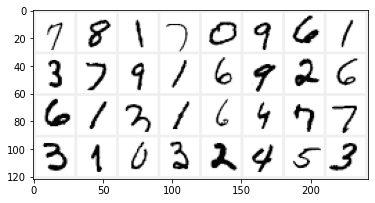

In [10]:
# create grid of images
dataiter = iter(trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


### Create combined rotated and unrotated MNIST image dataset of the digits 1-5

In [11]:
from PIL import Image
def rotate_dataset(d, rotation):
    result = torch.FloatTensor(d.size(0), 1, 28,28)
    tensor = transforms.ToTensor()
    norm = transforms.Normalize((0.1307,), (0.3081,)) 
    
    for i in range(d.size(0)):
        img = Image.fromarray(d[i].numpy(), mode='L')
        result[i] = norm(TF.rotate(tensor(img), rotation))
    return result

In [12]:
rot = 90

rot_train = rotate_dataset(trainset.data, rot)
rot_test= rotate_dataset(testset.data, rot)

In [13]:
# Function to extract subset of classes from the datasets
def filter_classes(classes_sub, classes_full, size, targets):
    print(classes_sub)
    start = 0
    labels = targets
    index = []
    per_class_size = ceil(size/len(classes_sub))
    for t in classes_sub:
        i = classes_full.index(t)
        index += list(np.where(labels == i)[0])[0:per_class_size]
    return index[0:size]

In [14]:
classes_mnist = ['0','1','2','3','4','5','6','7','8','9']

In [15]:
mnist_indices_train = filter_classes(classes_mnist[0:5], classes_mnist, int(trainsize/2), trainset.targets)
mnist_indices_test = filter_classes(classes_mnist[0:5], classes_mnist, int(testsize/2), testset.targets)

['0', '1', '2', '3', '4']
['0', '1', '2', '3', '4']


In [16]:
# shifting the labels by 5 to avoid overlap when selecting digits 1-5
classes_rot_mnist = ['5','6','7','8','9','10','11','12','13','14']

In [17]:
rot_trainset = TensorDataset(rot_train, trainset.targets+5)
rot_testset = TensorDataset(rot_test, testset.targets+5)

In [18]:
rot_trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(rot_trainset,mnist_indices_train), batch_size=batch_size,
                                          shuffle=True, num_workers=1, pin_memory=True)
rot_testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(rot_trainset,mnist_indices_test), batch_size=len(mnist_indices_test),
                                         shuffle=True, num_workers=1, pin_memory=True)

In [19]:
classes_rot_unrot_mnist = ['1','2','3','4','5','rotated 1', 'rotated 2', 'rotated 3', 'rotated 4', 'rotated 5']

Data samples


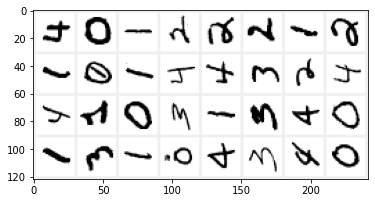

In [20]:
# create grid of images
dataiter = iter(rot_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


In [21]:
rot_unrot_trainset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(trainset,mnist_indices_train), 
                                                 torch.utils.data.Subset(rot_trainset,mnist_indices_train)])
rot_unrot_testset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(testset,mnist_indices_test),
                                                torch.utils.data.Subset(rot_testset,mnist_indices_test)])

In [22]:
rot_unrot_trainloader = torch.utils.data.DataLoader(rot_unrot_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1, pin_memory=True)
rot_unrot_testloader = torch.utils.data.DataLoader(rot_unrot_testset, batch_size=len(rot_unrot_testset),
                                         shuffle=True, num_workers=1, pin_memory=True)

Data samples


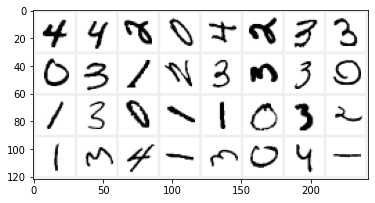

In [23]:
# create grid of images
dataiter = iter(rot_unrot_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


## Create combined FMNIST and MNIST dataset

In [24]:
# transforms: Convert PIL image to tensors and normalize
fmnist_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.2859,), (0.3530,))]) 

In [25]:
fmnist_trainset = torchvision.datasets.FashionMNIST('data', transform=fmnist_transform, train=True, download=True)

In [26]:
fmnist_testset = torchvision.datasets.FashionMNIST('data',transform=fmnist_transform, train=False)

In [27]:
# Since we are combining the fashion mnist and mnist data that have the same numerical labels from 0-9 
# we want to offset the mnist target so there is no overlap of the labels
def target_transform(target):
    return target+2

In [28]:
mnist_trainset = torchvision.datasets.MNIST('data', transform=mnist_transform, target_transform=target_transform, train=True, download=True)

In [29]:
mnist_testset = torchvision.datasets.MNIST('data',transform=mnist_transform, target_transform=target_transform, train=False)

In [30]:
classes_fmnist = ['t-shirt', 'Trouser', 'Pullover','Dress','Coat','Sandal',
                  'Shirt','Sneaker','Bag','Ankle boot']
classes_mnist = ['0','1','2','3','4','5','6','7','8','9']

# Combined fmnist and mnist classes. 
classes_fmnist_mnist = classes_fmnist[0:6]+[str(n) for n in range(4,10)]
print('classes_fmnist_mnist', classes_fmnist_mnist)

classes_fmnist_mnist ['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', '4', '5', '6', '7', '8', '9']


In [31]:
# Function to extract subset of classes from the datasets
def filter_classes(classes_sub, classes_full, size, data):
    print(classes_sub)
    start = 0
    labels = data.targets
    index = []
    per_class_size = ceil(size/len(classes_sub))
    for t in classes_sub:
        i = classes_full.index(t)
        index += list(np.where(labels == i)[0])[0:per_class_size]
    return index[0:size]

In [32]:
# Get the data for first 6 classes of fmnist dataset
fmnist_indices_train = filter_classes(classes_fmnist[0:6], classes_fmnist, int(trainsize/2), fmnist_trainset)
fmnist_indices_test = filter_classes(classes_fmnist[0:6], classes_fmnist, int(testsize/2), fmnist_testset)

['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal']
['t-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal']


In [33]:
fmnist_trainset.targets[fmnist_indices_train]

tensor([0, 0, 0,  ..., 5, 5, 5])

In [34]:
# Get the data for last 6 classes of fmnist dataset
mnist_indices_train = filter_classes(classes_mnist[4:], classes_mnist, int(trainsize/2), mnist_trainset)
mnist_indices_test = filter_classes(classes_mnist[4:], classes_mnist, int(testsize/2), mnist_testset)

['4', '5', '6', '7', '8', '9']
['4', '5', '6', '7', '8', '9']


In [35]:
# Create the combined dataset with fmnist and mnist classes
fmnist_mnist_trainset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(fmnist_trainset,fmnist_indices_train), 
                         torch.utils.data.Subset(mnist_trainset,mnist_indices_train)])
fmnist_mnist_testset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(fmnist_testset,fmnist_indices_test), 
                        torch.utils.data.Subset(mnist_testset,mnist_indices_test)])
train_size = len(fmnist_indices_train)+len(mnist_indices_train)
test_size = len(fmnist_indices_test)+len(mnist_indices_test)
print("Train size", train_size)
print("Test size", test_size)

Train size 60000
Test size 10000


In [36]:
fmnist_mnist_trainloader = torch.utils.data.DataLoader(fmnist_mnist_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1, pin_memory=True)
fmnist_mnist_testloader = torch.utils.data.DataLoader(fmnist_mnist_testset, batch_size=len(fmnist_mnist_testset),
                                         shuffle=True, num_workers=1, pin_memory=True)

In [37]:
num_classes_fmnist_mnist = len(classes_fmnist_mnist)

Data samples


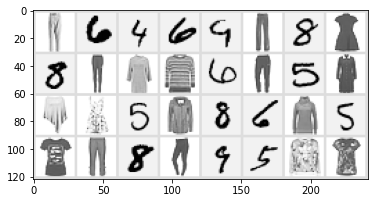

In [38]:
# create grid of images
dataiter = iter(fmnist_mnist_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32].view(-1, 1, 28, 28).type(torch.float))

print('Data samples')
# show images
imshow(img_grid, one_channel=True)

## Create imbalanced MNIST trainset

In [39]:
def imbalance_dataset(labels, fracs, selected_labels, size):
    
    unique_labels = torch.unique(labels)
    per_class_size = ceil(size/len(unique_labels))
    all_indices = []
    for l in unique_labels:
        indices = torch.where(labels == l)[0][0:per_class_size]
        if l in selected_labels:
            frac = fracs[np.random.randint(0,len(fracs),1)[0]]
        else:
            frac = 1.0
        selected_indices = list(np.random.choice(indices, int(frac*len(indices))))
        all_indices = all_indices + selected_indices
    return all_indices



In [40]:
# fracs = [0.25,0.5,0.75, 1.0]
# fracs = [0.3]

# imbalanced_indices = imbalance_dataset(trainset.targets, fracs, [0,1,2,3,4,6,7,8,9], trainsize*3) 

# imbalanced_trainset = torch.utils.data.Subset(trainset,imbalanced_indices)

# torch.save(imbalanced_trainset, open('data/imbalanced_dataset_5.data', 'wb'))

In [41]:
imbalanced_trainset = torch.load(open('data/imbalanced_dataset_5.data', 'rb'))

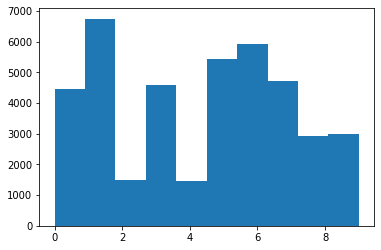

In [42]:
imbalanced_trainloader_all = torch.utils.data.DataLoader(imbalanced_trainset, 
                                                         batch_size=len(imbalanced_trainset),
                                                         shuffle=True, num_workers=1, pin_memory=True)
for _, labels in imbalanced_trainloader_all:
    plt.hist(labels.numpy(), align='mid')

In [43]:
imbalanced_trainloader = torch.utils.data.DataLoader(imbalanced_trainset, batch_size=64,
                                          shuffle=True, num_workers=1, pin_memory=True)

Data samples


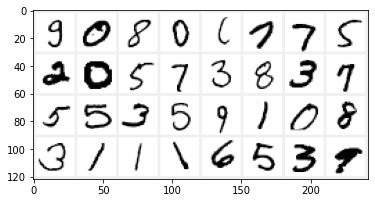

In [44]:
# create grid of images
dataiter = iter(imbalanced_trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images[0:32].view(-1, 1, 28, 28).type(torch.float))

print('Data samples')
# show images
imshow(img_grid, one_channel=True)

## Define expert and gate networks

In [45]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, num_classes, channels=1):
        super(expert_layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=1, kernel_size=3)
        self.fc1 = nn.Linear(in_features=1*13*13, out_features=64) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=64, out_features=32) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=32, out_features=num_classes)
                
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        # print('conv1', t.shape)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # print('max pool', t.shape)
        # fc1
        t = t.reshape(-1, 1*13*13)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
                      
        self.hidden = t
            
        t = F.relu(t)
                
        # output
        t = F.softmax(self.out(t), dim=1)
        
        return t

In [46]:
# Convolutional network with one convolutional layer and 2 hidden layers with ReLU activation
class gate_attn_layers(nn.Module):
    def __init__(self, num_experts, channels=1):
        super(gate_attn_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=1, kernel_size=3)

        self.fc1 = nn.Linear(in_features=1*13*13, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=32)
                
    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        
        return t


In [47]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts, channels=1):
        super(gate_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=1, kernel_size=3)

        self.fc1 = nn.Linear(in_features=1*13*13, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=num_experts)
        self.num_experts = num_experts

    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        t = F.softmax(t/T, dim=1)
        return t


In [48]:
# create a set of experts
def experts(num_experts, num_classes, expert_layers_type=expert_layers, channels=1):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(num_classes, channels))
    return nn.ModuleList(models)

In [49]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class single_model(nn.Module):
    def __init__(self, num_classes=10):
        super(single_model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
        self.fc1 = nn.Linear(in_features=1*13*13, out_features=64) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=64, out_features=32) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=32, out_features=num_classes)
        
        self.num_classes = num_classes
        
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*13*13)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
        
        return t

## Initialize configurations and helper functions

In [50]:
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

## Funtion to train MoR in: 
### (1) dual temp mode where experts and gates are trained with different temperatures
### (2) with regularization
### (3) dual temp and regularization
### (4) without regularization when w_importance = 0.
### (5) training the whole model end-to-end when T = 0.

### NOTE: when importance is set to 0 then it is the default training without regularization

In [51]:
def train_with_attention(model_1, trainloader, testloader, runs, temps, w_importance_range=[0], 
                         w_sample_sim_same_range=[0.0], w_sample_sim_diff_range=[0.0],
                         num_classes=10, total_experts=5, num_epochs=20, channels=1):
    
    hidden = 32
    
    for T, w_importance, w_sample_sim_same, w_sample_sim_diff, in product(temps, w_importance_range,w_sample_sim_same_range,  w_sample_sim_diff_range):
        
        print('Temperature',['{:.1f}'.format(t) for t in T])
        print('w_importance','{:.1f}'.format(w_importance))
        if w_sample_sim_same < 1:
            print('w_sample_sim_same',str(w_sample_sim_same))
        else:
            print('w_sample_sim_same','{:.1f}'.format(w_sample_sim_same))
        
        if w_sample_sim_diff < 1:
            print('w_sample_sim_diff',str(w_sample_sim_diff))
        else:
            print('w_sample_sim_diff','{:.1f}'.format(w_sample_sim_diff))

        n_run_models_1 = []
        for run in range(runs):

            print('Run:', run), 

            models = {'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss(),
                                               'experts':{}},}
            for key, val in models.items():

                expert_models = experts(total_experts, num_classes, channels=channels).to(device)
                
                gate_model = gate_attn_layers(total_experts, channels).to(device)

                moe_model = val['model'](total_experts, num_classes, attention_flag=1, hidden=hidden, 
                                         experts=expert_models, gate=gate_model).to(device)
                
                optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)
                

                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe = optimizer_moe,
                                       T = T, w_importance=w_importance, 
                                       w_sample_sim_same = w_sample_sim_same, w_sample_sim_diff = w_sample_sim_diff, 
                                       accuracy=accuracy, epochs=num_epochs)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}
            
            # Save all the trained models
            plot_file = generate_plot_file(model_1, T[0], w_importance=w_importance, 
                                           w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')
            
            
            if run > 1:
                n_run_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
                
            n_run_models_1.append(models)                                
            torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))
            n_run_models_1 = []
        print(plot_file)

In [65]:
def train_from_model(m, num_epochs, num_classes, total_experts, w_importance_range=[0.0], w_sample_sim_same_range=[0.0], w_sample_sim_diff_range=[0.0],
                     trainloader=None, testloader=None, expert_no_grad=True, gate_no_grad=False):
    
    T = [1.0]*num_epochs
    for w_importance, w_sample_sim_same, w_sample_sim_diff in product(w_importance_range, w_sample_sim_same_range, w_sample_sim_diff_range):
        
        print('w_importance','{:.1f}'.format(w_importance))
        
        if w_sample_sim_same < 1:
            print('w_sample_sim_same',str(w_sample_sim_same))
        else:
            print('w_sample_sim_same','{:.1f}'.format(w_sample_sim_same))
        
        if w_sample_sim_diff < 1:
            print('w_sample_sim_diff',str(w_sample_sim_diff))
        else:
            print('w_sample_sim_diff','{:.1f}'.format(w_sample_sim_diff))
        
        plot_file = generate_plot_file(m, temp=T[0], w_importance=w_importance,  
                                       w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                       specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

        attn_models = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

        n_run_models_1 = []
        run = 0
        for model in attn_models: 
            print('Run:', run)
            new_expert_models = experts(total_experts, num_classes).to(device)
            old_expert_models = model['moe_expectation_model']['experts'][total_experts]['model'].experts
            for i, expert in enumerate(new_expert_models):
                old_expert = old_expert_models[i]
                expert.load_state_dict(old_expert.state_dict())
                if expert_no_grad:
                    for param in expert.parameters():
                        param.requires_grad = False

            new_gate_model = gate_layers(total_experts).to(device)
            old_gate_model = model['moe_expectation_model']['experts'][total_experts]['model'].gate
            new_gate_model.load_state_dict(old_gate_model.state_dict(), strict=False)

            if gate_no_grad:
                for param in new_gate_model.parameters():
                    param.requires_grad = False
                new_gate_model.out = nn.Linear(in_features=32, out_features=num_experts)
                
            gate_model = new_gate_model

            models = {'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss(),
                                           'experts':{}},}

            for key, val in models.items():

                # gate_model = gate_layers(total_experts).to(device)                

                moe_model = val['model'](total_experts, num_classes,
                                         experts=new_expert_models, gate= gate_model).to(device)

                optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)


                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe = optimizer_moe,
                                       T = T, accuracy=accuracy, epochs=num_epochs)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}

            plot_file = generate_plot_file('new_'+m, T[0], w_importance=w_importance, w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')
        
            if run > 1:
                n_run_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
                
            n_run_models_1.append(models)                                
            torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))
            n_run_models_1 = []
            print(plot_file)
            
            run+=1


## Experiment 1: MoE model training with attention

### MNIST data

In [1]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_with_attention_hidden_32'

In [2]:
total_experts = 5

In [3]:
num_epochs = 1

In [5]:
temps = [[1.0]*num_epochs]
temps

[[1.0]]

In [6]:
runs = 1

In [7]:
train_with_attention(model_1, trainloader, testloader, runs, temps, num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

NameError: name 'train_with_attention' is not defined

### MNIST imbalanced data

In [ ]:
# Model with gate and expert parameters initialized to default values
model_1 = 'mnist_imbalanced_5_dual_temp'

In [ ]:
total_experts = 5

In [ ]:
num_epochs = 20

In [ ]:
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 6)))
temps

In [ ]:
w_importance_range = [0.0]

In [ ]:
runs = 10

In [ ]:
train_dual_temp_regularization_model(model_1, imbalanced_trainloader, testloader, runs, temps, w_importance_range, num_classes, total_experts, num_epochs)

### Combined rotated and unrotated MNIST data

In [69]:
# Model with gate and expert parameters initialized to default values
model_1 = 'rot_mnist_with_attention_hidden_32'

In [70]:
total_experts = 5

In [71]:
num_epochs = 20

In [72]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [73]:
runs = 10

In [74]:
train_with_attention(model_1, rot_unrot_trainloader, rot_unrot_testloader, runs, temps, num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
Run: 0
epoch 0 training loss 1.06 , training accuracy 0.73 , test accuracy 0.89
epoch 1 training loss 0.26 , training accuracy 0.93 , test accuracy 0.94
epoch 2 training loss 0.18 , training accuracy 0.95 , test accuracy 0.95
epoch 3 training loss 0.15 , training accuracy 0.96 , test accuracy 0.95
epoch 4 training loss 0.12 , training accuracy 0.97 , test accuracy 0.96
epoch 5 training loss 0.10 , training accuracy 0.97 , test accuracy 0.96
epoch 6 training loss 0.08 , training accuracy 0.98 , test accuracy 0.96
epoch 7 training loss 0.08 , training accuracy 0.98 , test accuracy 0.97
epoch 8 training loss 0.06 , training accuracy 0.98 , test accuracy 0.97
epoch 9 training loss 0.06 , training accuracy 0.99 , test accuracy 0.97
epoch 10 training loss 0.05 , training accuracy 0.99 , test accuracy 0.97
epoch 11 training l

### Combined FMNIST MNIST data

In [75]:
# Model with gate and expert parameters initialized to default values
model_1 = 'fmnist_mnist_with_attention_hidden_32'

In [76]:
total_experts = 6

In [77]:
num_epochs = 20

In [78]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [79]:
runs = 10

In [80]:
train_with_attention(model_1, fmnist_mnist_trainloader, fmnist_mnist_testloader, runs, temps, num_classes=num_classes_fmnist_mnist, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
Run: 0
epoch 0 training loss 1.42 , training accuracy 0.62 , test accuracy 0.77
epoch 1 training loss 0.50 , training accuracy 0.84 , test accuracy 0.84
epoch 2 training loss 0.39 , training accuracy 0.88 , test accuracy 0.85
epoch 3 training loss 0.33 , training accuracy 0.89 , test accuracy 0.88
epoch 4 training loss 0.30 , training accuracy 0.90 , test accuracy 0.88
epoch 5 training loss 0.28 , training accuracy 0.91 , test accuracy 0.88
epoch 6 training loss 0.27 , training accuracy 0.91 , test accuracy 0.88
epoch 7 training loss 0.25 , training accuracy 0.92 , test accuracy 0.89
epoch 8 training loss 0.23 , training accuracy 0.92 , test accuracy 0.89
epoch 9 training loss 0.23 , training accuracy 0.92 , test accuracy 0.89
epoch 10 training loss 0.22 , training accuracy 0.93 , test accuracy 0.89
epoch 11 training l

### CIFAR data

In [60]:
# Model with gate and expert parameters initialized to default values
model_1 = 'cifar_with_attention_hidden_32'

In [61]:
total_experts = 5

In [62]:
num_epochs = 20

In [63]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [64]:
runs = 1

In [65]:
train_with_attention(model_1, cifar_trainloader, cifar_testloader, runs, temps, num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs, channels=3)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
Run: 0
epoch 0 training loss 2.26 , training accuracy 0.14 , test accuracy 0.16
epoch 1 training loss 2.05 , training accuracy 0.21 , test accuracy 0.23
epoch 2 training loss 1.98 , training accuracy 0.26 , test accuracy 0.27
epoch 3 training loss 1.91 , training accuracy 0.28 , test accuracy 0.28
epoch 4 training loss 1.87 , training accuracy 0.30 , test accuracy 0.31
epoch 5 training loss 1.84 , training accuracy 0.31 , test accuracy 0.31
epoch 6 training loss 1.82 , training accuracy 0.32 , test accuracy 0.33
epoch 7 training loss 1.79 , training accuracy 0.34 , test accuracy 0.34
epoch 8 training loss 1.76 , training accuracy 0.35 , test accuracy 0.35
epoch 9 training loss 1.73 , training accuracy 0.36 , test accuracy 0.35
epoch 10 training loss 1.71 , training accuracy 0.37 , test accuracy 0.35
epoch 11 training l

## Experiment 2: MoE model training with attention and gate regularization

### MNIST data

In [111]:
# Model with gate and expert parameters initialized to default values
model_2 = 'mnist_with_attn_reg_hidden_32'

In [112]:
total_experts = 5

In [113]:
num_epochs = 20

In [114]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [115]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [116]:
runs = 10

In [117]:
train_with_attention(model_2, trainloader, testloader, runs, temps, w_importance_range, 
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.2
w_ortho 0.0
Run: 0
epoch 0 training loss 1.49 , training accuracy 0.60 , test accuracy 0.74
epoch 1 training loss 0.56 , training accuracy 0.86 , test accuracy 0.83
epoch 2 training loss 0.38 , training accuracy 0.91 , test accuracy 0.87
epoch 3 training loss 0.32 , training accuracy 0.92 , test accuracy 0.89
epoch 4 training loss 0.26 , training accuracy 0.94 , test accuracy 0.91
epoch 5 training loss 0.24 , training accuracy 0.95 , test accuracy 0.92
epoch 6 training loss 0.21 , training accuracy 0.95 , test accuracy 0.92
epoch 7 training loss 0.19 , training accuracy 0.96 , test accuracy 0.92
epoch 8 training loss 0.18 , training accuracy 0.96 , test accuracy 0.93
epoch 9 training loss 0.16 , training accuracy 0.97 , test accuracy 0.92
epoch 10 training loss 0.15 , training accuracy 0.97 , test accuracy 0.93
epoch 1

### MNIST imbalanced data

In [ ]:
# Model with gate and expert parameters initialized to default values
model_2 = 'mnist_imbalanced_5_with_regularization'

In [ ]:
total_experts = 5

In [ ]:
num_epochs = 20

In [ ]:
temps = [1.0]

In [8]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range 

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [9]:
runs = 10

In [10]:
train_dual_temp_regularization_model(model_2, imbalanced_trainloader, testloader, runs, temps, w_importance_range, num_classes, total_experts, num_epochs)

NameError: name 'train_dual_temp_regularization_model' is not defined

### Combined rotated and unrotated MNIST data

In [54]:
# Model with gate and expert parameters initialized to default values
model_2 = 'rot_mnist_with_attn_reg_hidden_32'

In [55]:
total_experts = 5

In [56]:
num_epochs = 20

In [57]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [58]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [59]:
runs = 10

In [60]:
train_with_attention(model_2, rot_unrot_trainloader, rot_unrot_testloader, runs, temps, w_importance_range=w_importance_range, num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.2
Run: 0
epoch 0 training loss 1.31 , training accuracy 0.71 , test accuracy 0.88
epoch 1 training loss 0.35 , training accuracy 0.92 , test accuracy 0.93
epoch 2 training loss 0.25 , training accuracy 0.95 , test accuracy 0.94
epoch 3 training loss 0.21 , training accuracy 0.96 , test accuracy 0.95
epoch 4 training loss 0.18 , training accuracy 0.97 , test accuracy 0.96
epoch 5 training loss 0.17 , training accuracy 0.97 , test accuracy 0.96
epoch 6 training loss 0.15 , training accuracy 0.98 , test accuracy 0.96
epoch 7 training loss 0.13 , training accuracy 0.98 , test accuracy 0.97
epoch 8 training loss 0.13 , training accuracy 0.98 , test accuracy 0.96
epoch 9 training loss 0.11 , training accuracy 0.99 , test accuracy 0.97
epoch 10 training loss 0.11 , training accuracy 0.99 , test accuracy 0.96
epoch 11 training l

### Combined FMNIST MNIST data

In [88]:
# Model with gate and expert parameters initialized to default values
model_2 = 'fmnist_mnist_with_attn_reg_hidden_32'

In [89]:
total_experts = 6

In [90]:
num_epochs = 20

In [91]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [92]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
w_importance_range

[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [93]:
runs = 10

In [94]:
train_with_attention(model_2, fmnist_mnist_trainloader, fmnist_mnist_testloader, runs, temps=temps, w_importance_range=w_importance_range, 
                     num_classes=num_classes_fmnist_mnist, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.2
Run: 0
epoch 0 training loss 1.48 , training accuracy 0.58 , test accuracy 0.74
epoch 1 training loss 0.57 , training accuracy 0.82 , test accuracy 0.82
epoch 2 training loss 0.41 , training accuracy 0.87 , test accuracy 0.87
epoch 3 training loss 0.34 , training accuracy 0.89 , test accuracy 0.87
epoch 4 training loss 0.29 , training accuracy 0.91 , test accuracy 0.90
epoch 5 training loss 0.26 , training accuracy 0.92 , test accuracy 0.88
epoch 6 training loss 0.25 , training accuracy 0.92 , test accuracy 0.89
epoch 7 training loss 0.22 , training accuracy 0.93 , test accuracy 0.90
epoch 8 training loss 0.22 , training accuracy 0.93 , test accuracy 0.90
epoch 9 training loss 0.20 , training accuracy 0.94 , test accuracy 0.91
epoch 10 training loss 0.19 , training accuracy 0.94 , test accuracy 0.90
epoch 11 training l

## Experiment 3: MoE model training with attention and sample similarity regularization

### MNIST data

In [55]:
# Model with gate and expert parameters initialized to default values
model_2 = 'mnist_with_attn_sample_sim_reg_hidden_32'

In [56]:
total_experts = 5

In [57]:
num_epochs = 20

In [58]:
temps = [[1.0]*num_epochs]
temps

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]]

In [59]:
w_sample_sim_same_range = [1e-5]
w_sample_sim_diff_range = [1e-6]
w_sample_sim_same_range, w_sample_sim_diff_range

([1e-05], [1e-06])

In [60]:
runs = 10

In [61]:
train_with_attention(model_2, trainloader, testloader, runs, temps, 
                     w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range, 
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

Temperature ['1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0']
w_importance 0.0
w_sample_sim_same 1e-05
w_sample_sim_diff 1e-06
Run: 0
epoch 0 training loss 4.64 , training accuracy 0.68 , test accuracy 0.80
epoch 1 training loss 3.69 , training accuracy 0.86 , test accuracy 0.89
epoch 2 training loss 3.51 , training accuracy 0.90 , test accuracy 0.92
epoch 3 training loss 3.44 , training accuracy 0.92 , test accuracy 0.93
epoch 4 training loss 3.40 , training accuracy 0.93 , test accuracy 0.94
epoch 5 training loss 3.38 , training accuracy 0.94 , test accuracy 0.94
epoch 6 training loss 3.36 , training accuracy 0.95 , test accuracy 0.95
epoch 7 training loss 3.35 , training accuracy 0.95 , test accuracy 0.95
epoch 8 training loss 3.33 , training accuracy 0.95 , test accuracy 0.95
epoch 9 training loss 3.32 , training accuracy 0.96 , test accuracy 0.95
epoch 10 training loss 3.31 , training accura

## Retrain model without attention

In [54]:
m = 'mnist_with_attn_reg_hidden_32'

total_experts = 5
num_classes = 10
num_epochs = 20

w_importance_range = [i * 0.2 for i in range(1, 6)]


train_from_model(m, num_epochs, num_classes, total_experts, w_importance_range=w_importance_range, trainloader=trainloader, testloader=testloader)

w_importance 0.2
Run: 0
epoch 0 training loss 0.69 , training accuracy 0.77 , test accuracy 0.89
epoch 1 training loss 0.28 , training accuracy 0.91 , test accuracy 0.92
epoch 2 training loss 0.22 , training accuracy 0.93 , test accuracy 0.93
epoch 3 training loss 0.18 , training accuracy 0.95 , test accuracy 0.94
epoch 4 training loss 0.16 , training accuracy 0.95 , test accuracy 0.95
epoch 5 training loss 0.14 , training accuracy 0.96 , test accuracy 0.95
epoch 6 training loss 0.13 , training accuracy 0.96 , test accuracy 0.95
epoch 7 training loss 0.12 , training accuracy 0.96 , test accuracy 0.96
epoch 8 training loss 0.11 , training accuracy 0.97 , test accuracy 0.96
epoch 9 training loss 0.11 , training accuracy 0.97 , test accuracy 0.96
epoch 10 training loss 0.10 , training accuracy 0.97 , test accuracy 0.96
epoch 11 training loss 0.10 , training accuracy 0.97 , test accuracy 0.96
epoch 12 training loss 0.09 , training accuracy 0.97 , test accuracy 0.96
epoch 13 training loss 0

In [66]:
m = 'mnist_with_attn_sample_sim_reg_hidden_32'

total_experts = 5
num_classes = 10
num_epochs = 20

w_sample_sim_same_range = [1e-6]
w_sample_sim_diff_range = [1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1]

train_from_model(m, num_epochs, num_classes, total_experts, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                 trainloader=trainloader, testloader=testloader)

w_importance 0.0
w_sample_sim_same 1e-06
w_sample_sim_diff 1e-06
Run: 0
epoch 0 training loss 0.40 , training accuracy 0.90 , test accuracy 0.95
epoch 1 training loss 0.13 , training accuracy 0.96 , test accuracy 0.96
epoch 2 training loss 0.10 , training accuracy 0.97 , test accuracy 0.96
epoch 3 training loss 0.08 , training accuracy 0.98 , test accuracy 0.96
epoch 4 training loss 0.07 , training accuracy 0.98 , test accuracy 0.97
epoch 5 training loss 0.06 , training accuracy 0.98 , test accuracy 0.97
epoch 6 training loss 0.06 , training accuracy 0.98 , test accuracy 0.97
epoch 7 training loss 0.05 , training accuracy 0.98 , test accuracy 0.97
epoch 8 training loss 0.05 , training accuracy 0.99 , test accuracy 0.97
epoch 9 training loss 0.05 , training accuracy 0.99 , test accuracy 0.97
epoch 10 training loss 0.05 , training accuracy 0.99 , test accuracy 0.97
epoch 11 training loss 0.04 , training accuracy 0.99 , test accuracy 0.97
epoch 12 training loss 0.04 , training accuracy 0.

In [63]:
m = 'rot_mnist_with_attn_reg_hidden_32'

total_experts = 5
num_classes = 10
num_epochs = 20

w_importance_range = [i * 0.2 for i in range(1, 6)]

train_from_model(m, num_epochs, num_classes, total_experts, w_importance_range=w_importance_range, trainloader=rot_unrot_trainloader, testloader=rot_unrot_testloader)

Run: 1
epoch 0 training loss 0.51 , training accuracy 0.87 , test accuracy 0.92
epoch 1 training loss 0.15 , training accuracy 0.96 , test accuracy 0.93
epoch 2 training loss 0.12 , training accuracy 0.97 , test accuracy 0.95
epoch 3 training loss 0.10 , training accuracy 0.98 , test accuracy 0.95
epoch 4 training loss 0.09 , training accuracy 0.98 , test accuracy 0.95
epoch 5 training loss 0.08 , training accuracy 0.98 , test accuracy 0.96
epoch 6 training loss 0.08 , training accuracy 0.98 , test accuracy 0.96
epoch 7 training loss 0.07 , training accuracy 0.98 , test accuracy 0.96
epoch 8 training loss 0.07 , training accuracy 0.98 , test accuracy 0.96
epoch 9 training loss 0.07 , training accuracy 0.98 , test accuracy 0.96
epoch 10 training loss 0.06 , training accuracy 0.99 , test accuracy 0.96
epoch 11 training loss 0.06 , training accuracy 0.99 , test accuracy 0.96
epoch 12 training loss 0.06 , training accuracy 0.99 , test accuracy 0.96
epoch 13 training loss 0.06 , training ac

In [90]:
m = 'fmnist_mnist_with_attn_reg_hidden_32'

total_experts = 6
num_classes = num_classes_fmnist_mnist
num_epochs = 20

w_importance_range = [i * 0.2 for i in range(1, 6)]

train_from_model(m, num_epochs, num_classes, total_experts, w_importance_range=w_importance_range, trainloader=fmnist_mnist_trainloader, testloader=fmnist_mnist_testloader)

Run: 1

epoch 0 training loss 0.77 , training accuracy 0.76 , test accuracy 0.87
epoch 1 training loss 0.26 , training accuracy 0.92 , test accuracy 0.89
epoch 2 training loss 0.21 , training accuracy 0.93 , test accuracy 0.90
epoch 3 training loss 0.19 , training accuracy 0.93 , test accuracy 0.90
epoch 4 training loss 0.18 , training accuracy 0.94 , test accuracy 0.90
epoch 5 training loss 0.17 , training accuracy 0.94 , test accuracy 0.90
epoch 6 training loss 0.16 , training accuracy 0.95 , test accuracy 0.90
epoch 7 training loss 0.16 , training accuracy 0.95 , test accuracy 0.91
epoch 8 training loss 0.15 , training accuracy 0.95 , test accuracy 0.91
epoch 9 training loss 0.15 , training accuracy 0.95 , test accuracy 0.91
epoch 10 training loss 0.14 , training accuracy 0.95 , test accuracy 0.91
epoch 11 training loss 0.14 , training accuracy 0.96 , test accuracy 0.91
epoch 12 training loss 0.13 , training accuracy 0.96 , test accuracy 0.91
epoch 13 training loss 0.13 , training a

## Results

### Expert Usage

In [ ]:
m = 'new_mnist_with_attention_hidden_32_no_grad'
test_loader = testloader
plot_expert_usage(m, test_loader, classes=range(10) )

Min Validation Error 0.023
mnist_with_attn_reg_hidden_32_importance_1.0_10_5_models.pt
20 torch.Size([20, 60000, 5])


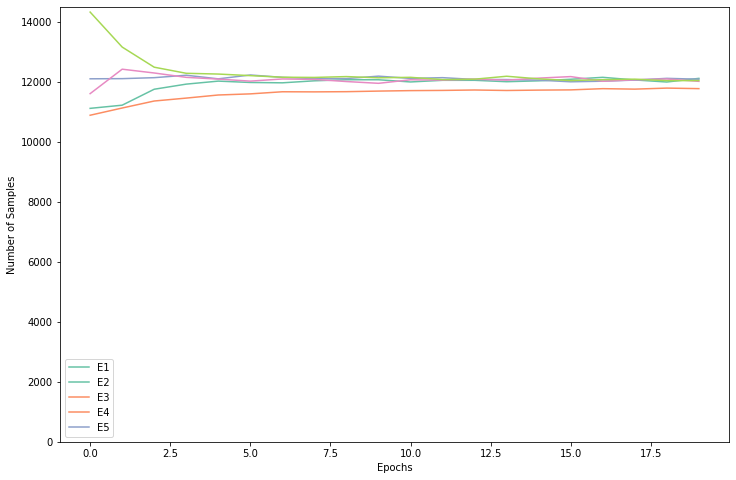

tensor([7, 2, 1,  ..., 4, 5, 6])


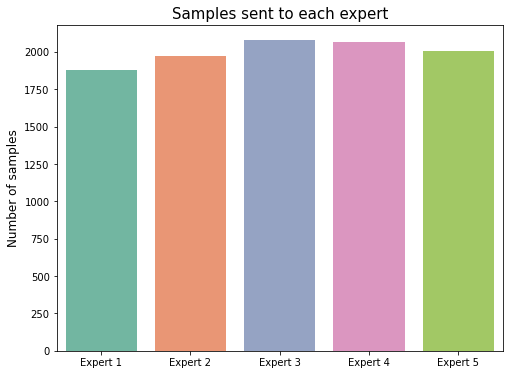

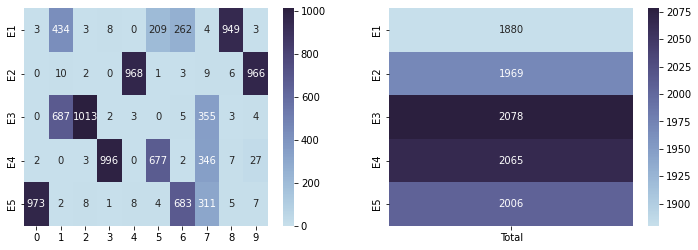


Experts used by the gate for classification of each digit


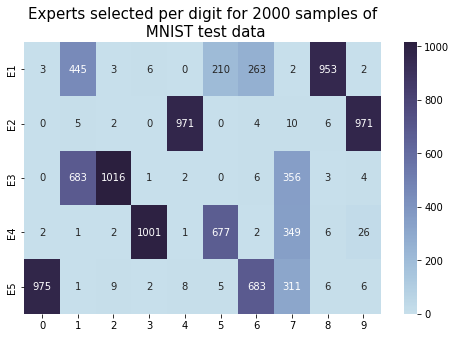

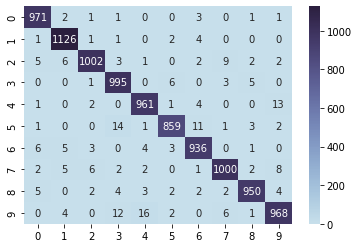

In [91]:
m = 'mnist_with_attn_reg_hidden_32'
test_loader = testloader
w_importance_range = [i * 0.2 for i in range(1, 6)]
plot_expert_usage(m, test_loader, w_importance_range=w_importance_range,classes=range(10),fig_path=fig_path, model_path=model_path )

Min Validation Error 0.022
mnist_with_attn_sample_sim_reg_hidden_32_sample_sim_same_1e-06_sample_sim_diff_1e-06_10_5_models.pt


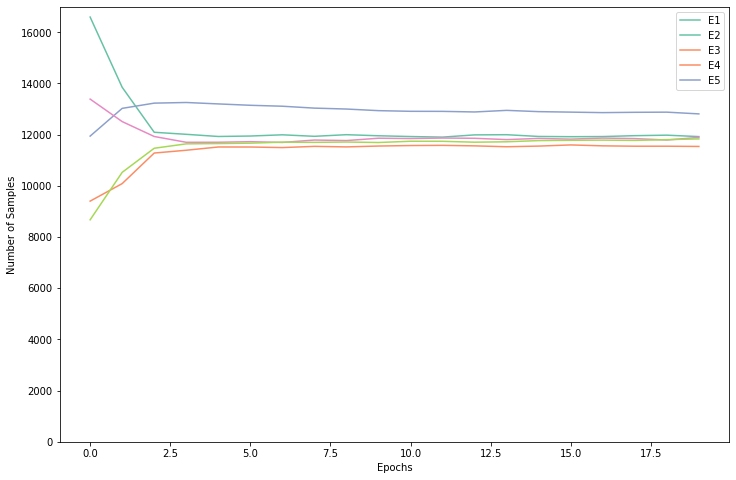

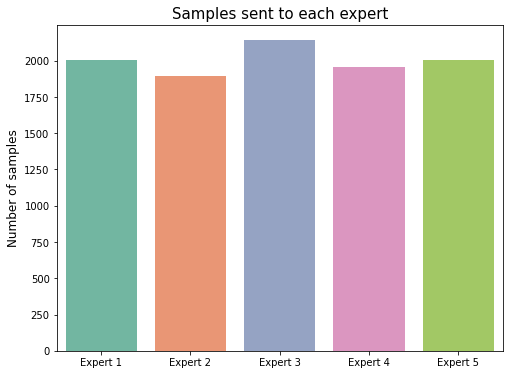

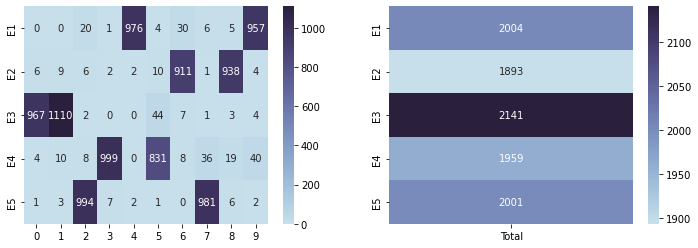


Experts used by the gate for classification of each digit


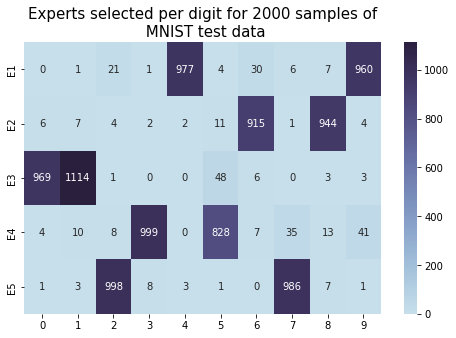

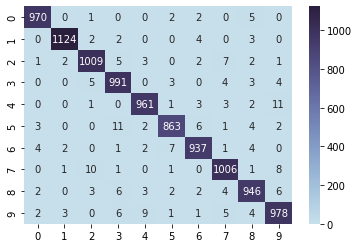

In [70]:
m = 'mnist_with_attn_sample_sim_reg_hidden_32'
test_loader = testloader
w_sample_sim_same_range = [1e-6]
w_sample_sim_diff_range =  [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
plot_expert_usage(m, test_loader, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                  classes=range(10),fig_path=fig_path, model_path=model_path )

new_mnist_with_attn_reg_hidden_32_no_grad_10_5_models.pt
20 torch.Size([20, 10000, 5])


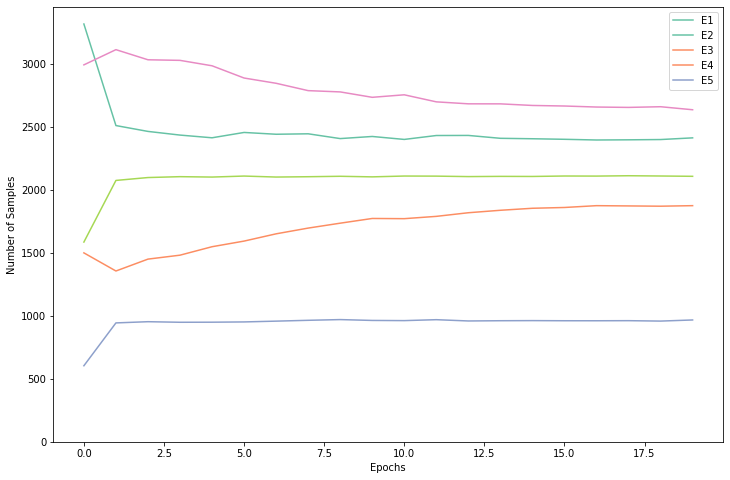

tensor([7, 2, 1,  ..., 3, 9, 5])


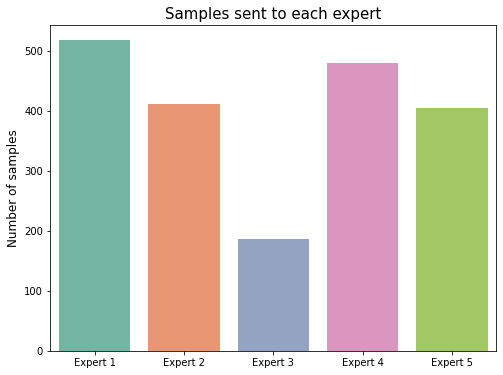

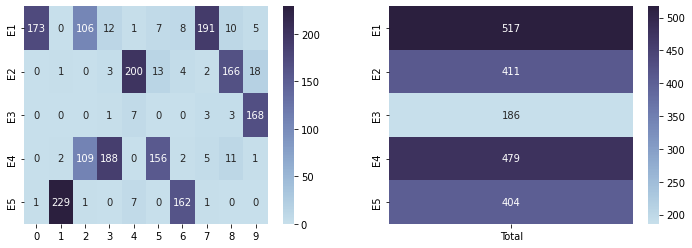


Experts used by the gate for classification of each digit


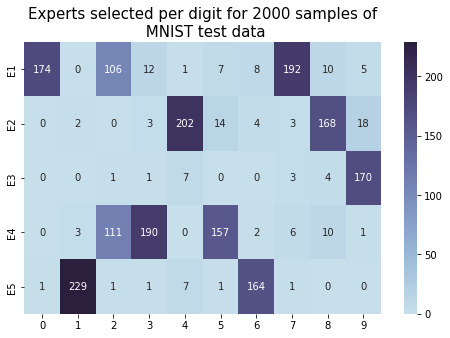

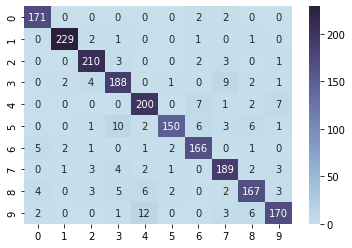

In [110]:
m = 'new_mnist_with_attn_reg_hidden_32_no_grad'
test_loader = testloader
plot_expert_usage(m, test_loader, classes=range(10) )

new_mnist_with_attn_reg_hidden_32_with_grad_10_5_models.pt
20 torch.Size([20, 10000, 5])


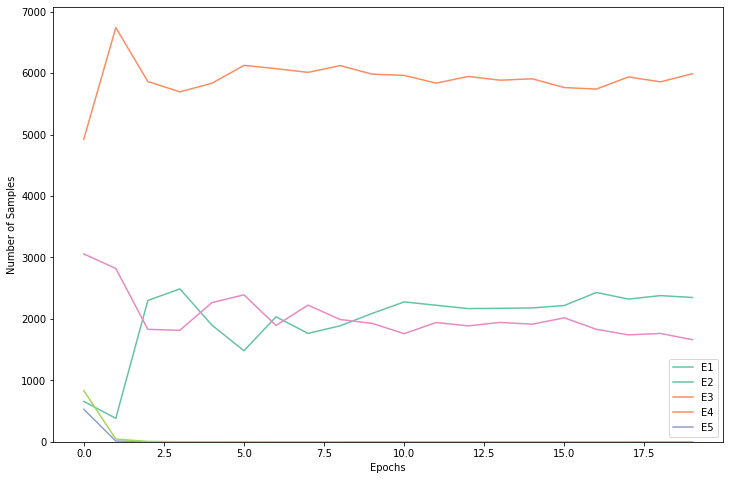

tensor([7, 2, 1,  ..., 3, 9, 5])


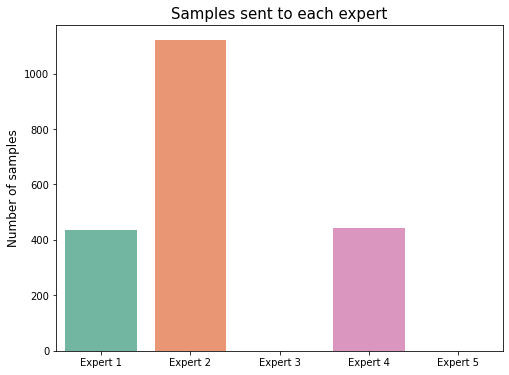

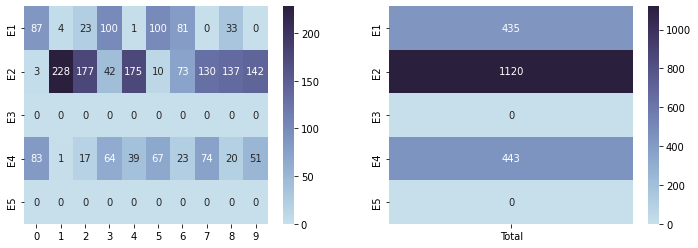


Experts used by the gate for classification of each digit


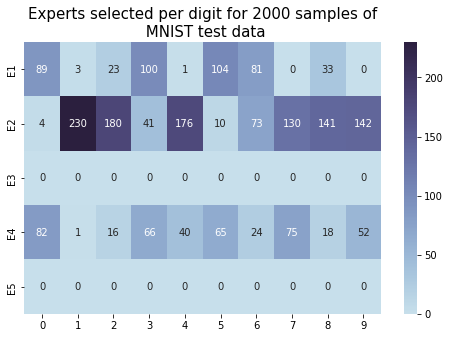

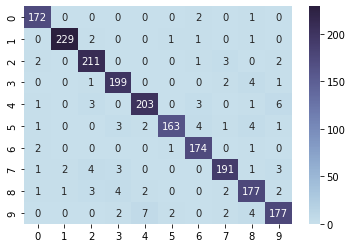

In [68]:
m = 'new_mnist_with_attn_reg_hidden_32_with_grad'
test_loader = testloader
plot_expert_usage(m, test_loader, classes=range(10) )

Min Validation Error 0.026
rot_mnist_with_attn_reg_hidden_32_importance_0.4_10_5_models.pt
20 torch.Size([20, 10000, 5])


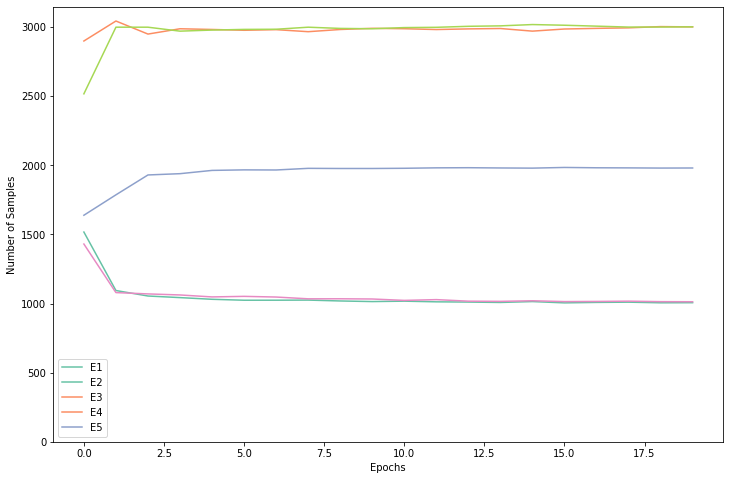

tensor([3, 4, 8,  ..., 0, 4, 6])


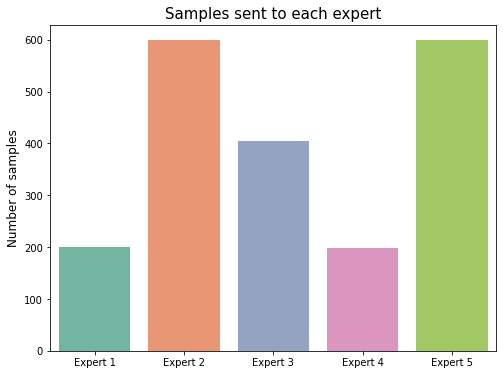

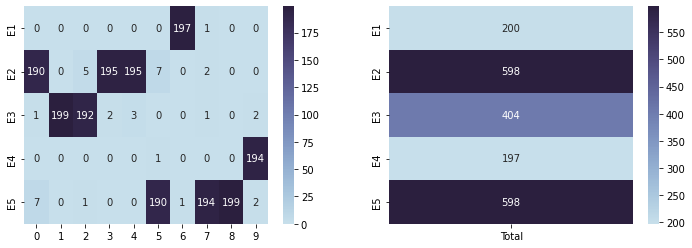


Experts used by the gate for classification of each digit


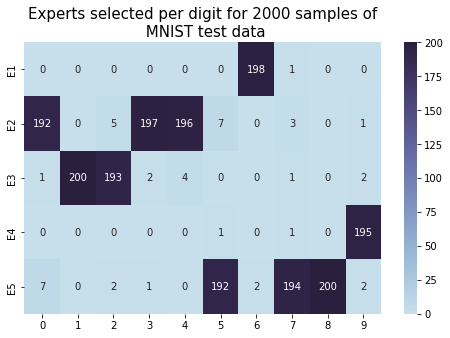

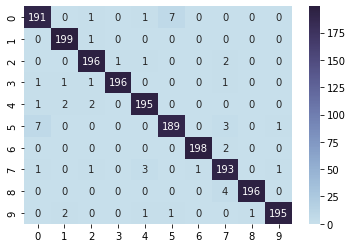

In [61]:
m = 'rot_mnist_with_attn_reg_hidden_32'
test_loader = rot_unrot_testloader
w_importance_range = [i * 0.2 for i in range(1, 6)]
plot_expert_usage(m, test_loader, w_importance_range=w_importance_range,classes=range(10),fig_path=fig_path, model_path=model_path )

Min Validation Error 0.067
fmnist_mnist_with_reg_hidden_32_importance_0.6_12_6_models.pt
20 torch.Size([20, 10000, 6])


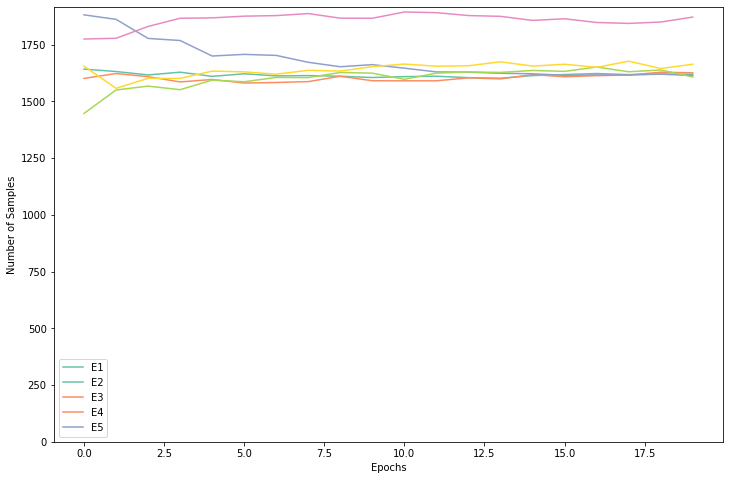

tensor([ 8, 11,  9,  ...,  4,  8,  8])


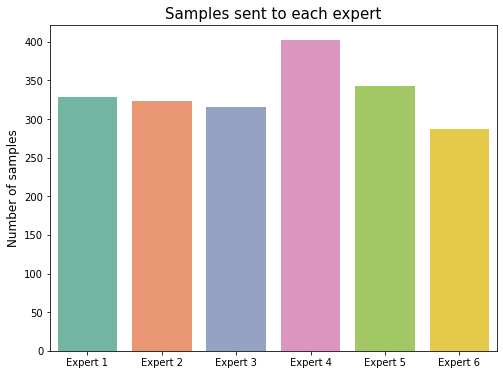

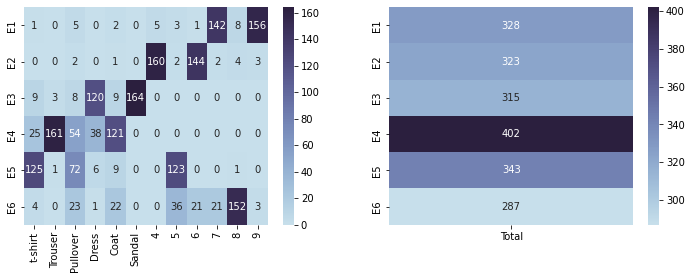


Experts used by the gate for classification of each digit


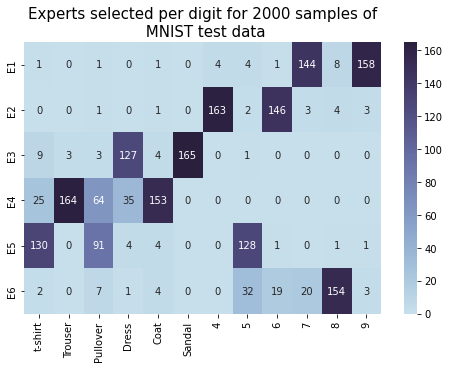

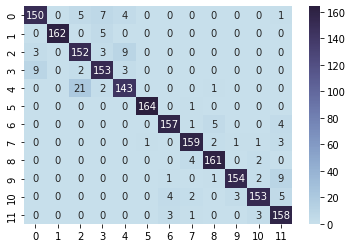

In [63]:
m = 'fmnist_mnist_with_reg_hidden_32'
test_loader = fmnist_mnist_testloader
w_importance_range = [i * 0.2 for i in range(1, 6)]
plot_expert_usage(m, test_loader, w_importance_range=w_importance_range,total_experts=6, num_classes=num_classes_fmnist_mnist, classes=classes_fmnist_mnist,
                  fig_path=fig_path, model_path=model_path )

Min Validation Error 0.071
fmnist_mnist_with_attn_reg_hidden_32_importance_0.2_12_6_models.pt
20 torch.Size([20, 10000, 6])


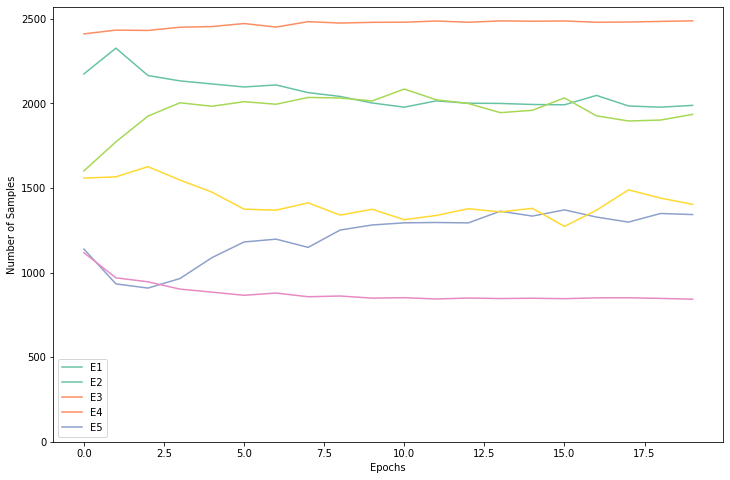

tensor([6, 8, 5,  ..., 1, 1, 8])


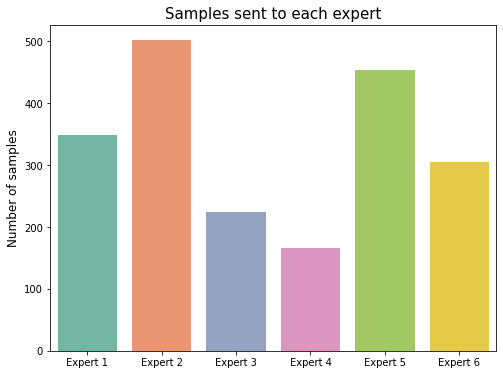

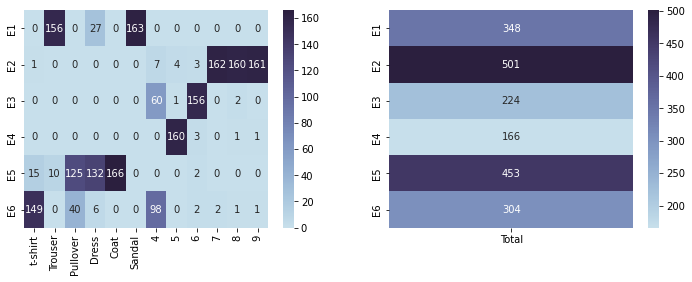


Experts used by the gate for classification of each digit


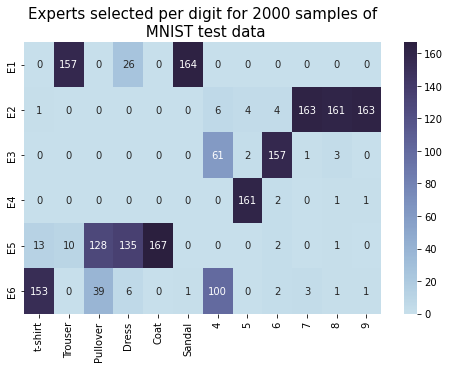

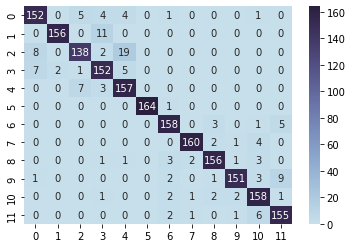

In [62]:
m = 'fmnist_mnist_with_attn_reg_hidden_32'
test_loader = fmnist_mnist_testloader
w_importance_range = [i * 0.2 for i in range(1, 6)]
plot_expert_usage(m, test_loader, w_importance_range=w_importance_range,total_experts=6, num_classes=num_classes_fmnist_mnist, classes=classes_fmnist_mnist,
                  fig_path=fig_path, model_path=model_path )

### Boxplots to compare multiple runs of different models

In [88]:
m = 'mnist_with_attn_reg_hidden_32'
# m = 'mnist_with_attention_hidden_32'
# m = 'mnist_with_reg_hidden_32'
# m = 'mnist_without_reg_hidden_32'
w_importance_range = [0.0]
w_importance_range = [i * 0.2 for i in range(1, 6)]
model, model_name = find_best_model(m, temps=[1.0], w_importance_range=w_importance_range, 
                    total_experts=5, num_classes=10, model_path=model_path)
model['moe_expectation_model']['experts'][total_experts]['history']['gate_probabilities'][0].shape

Min Validation Error 0.023


torch.Size([60000, 5])

<Figure size 432x288 with 0 Axes>

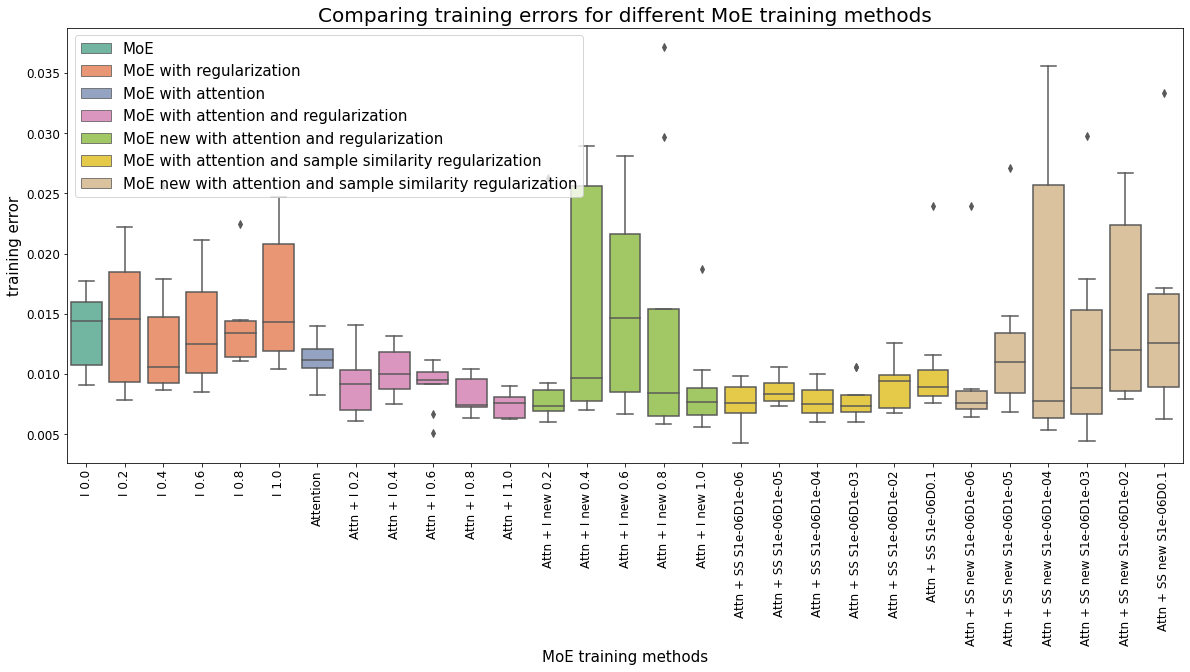

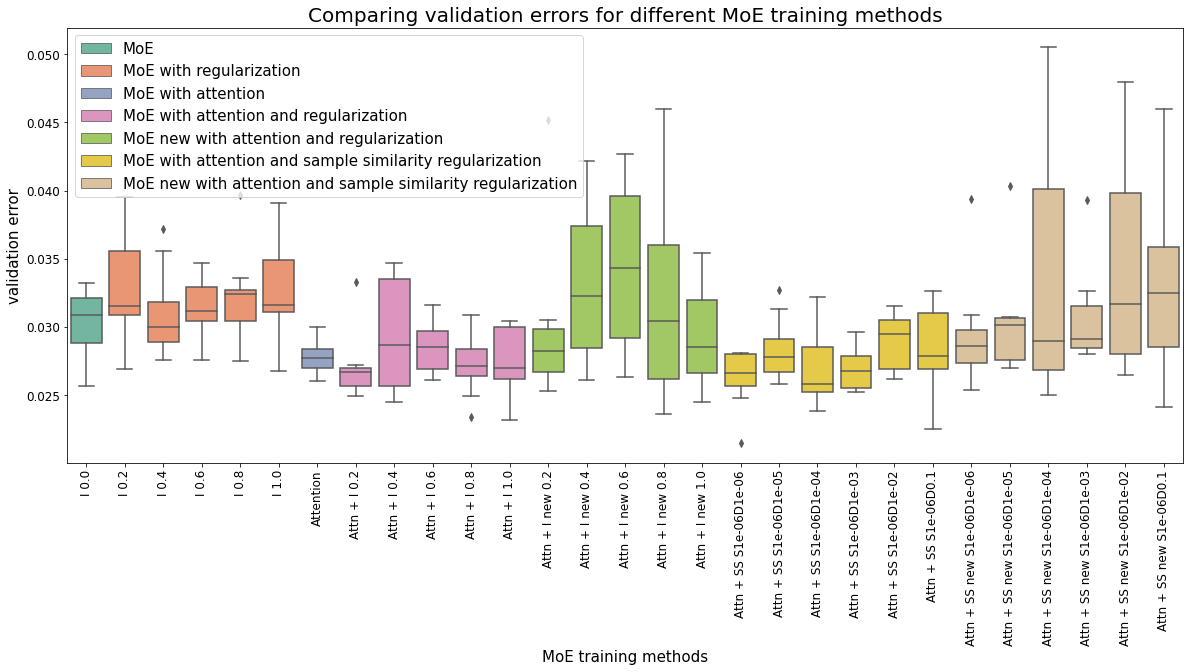

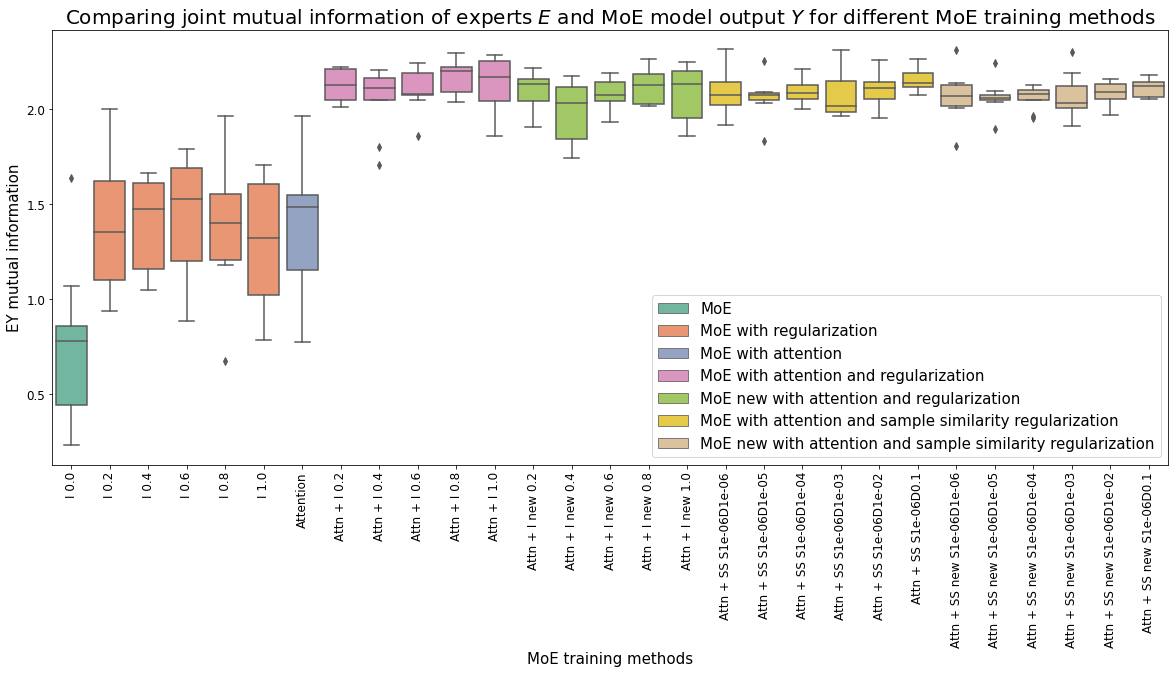

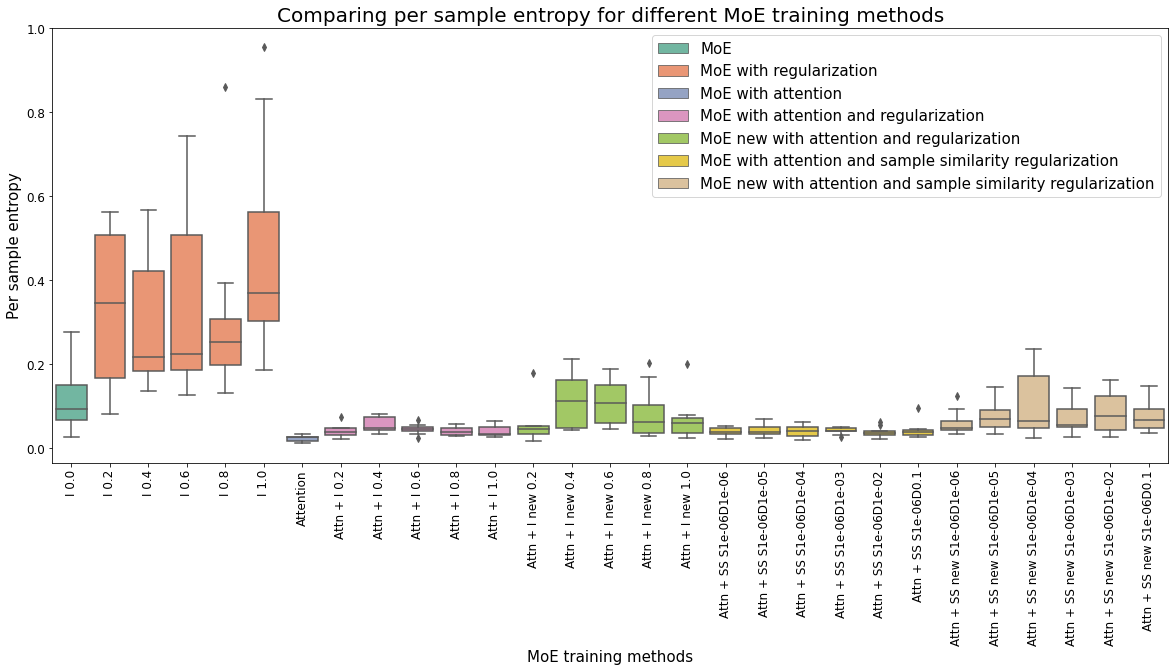

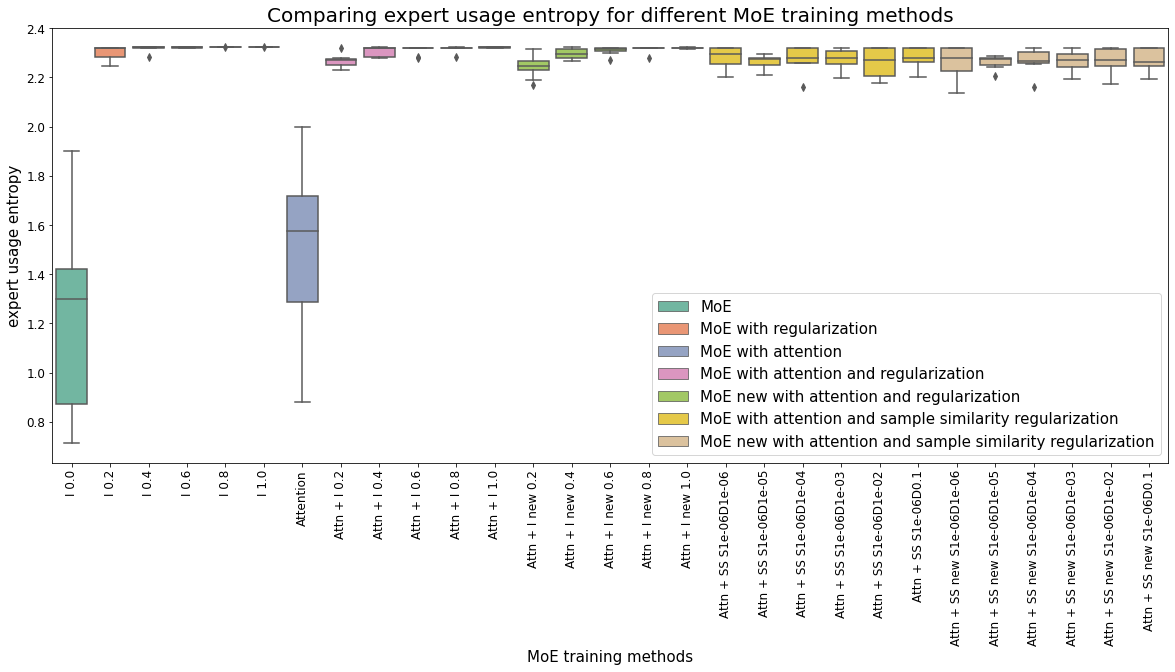

In [67]:
model_with_attention = {'ignore':'mnist_with_attention_hidden_32'}
model_with_attn_reg = {'ignore':'mnist_with_attn_reg_hidden_32', 'new':'new_mnist_with_attn_reg_hidden_32'}
model_with_reg = {'ignore':'mnist_with_reg_hidden_32'}
model_without_reg = {'ignore':'mnist_without_reg_hidden_32'}
model_with_attn_sample_sim_reg = {'ignore':'mnist_with_attn_sample_sim_reg_hidden_32', 'new':'new_mnist_with_attn_sample_sim_reg_hidden_32'}

figname='mnist_with_attention_hidden_32' 

total_experts = 5
num_classes = 10

w_importance_range = [i * 0.2 for i in range(1, 6)]

w_sample_sim_same_range = [1e-6]
w_sample_sim_diff_range = [1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1]

boxplot(model_with_reg=model_with_reg, model_without_reg=model_without_reg, model_with_attention=model_with_attention, 
        model_with_attn_reg=model_with_attn_reg, model_with_attn_sample_sim_reg=model_with_attn_sample_sim_reg,
        w_importance_range=w_importance_range, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
        total_experts=total_experts, num_classes=num_classes, classes=classes_mnist, 
        testloader=testloader, figname=figname , fig_path=fig_path, model_path=model_path)

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]


<Figure size 432x288 with 0 Axes>

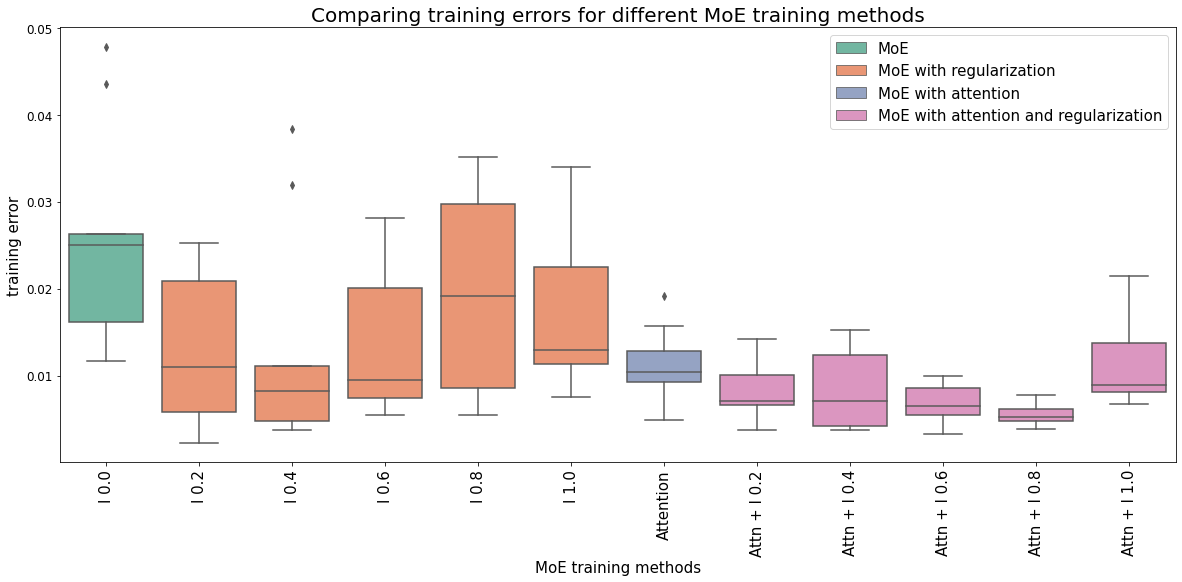

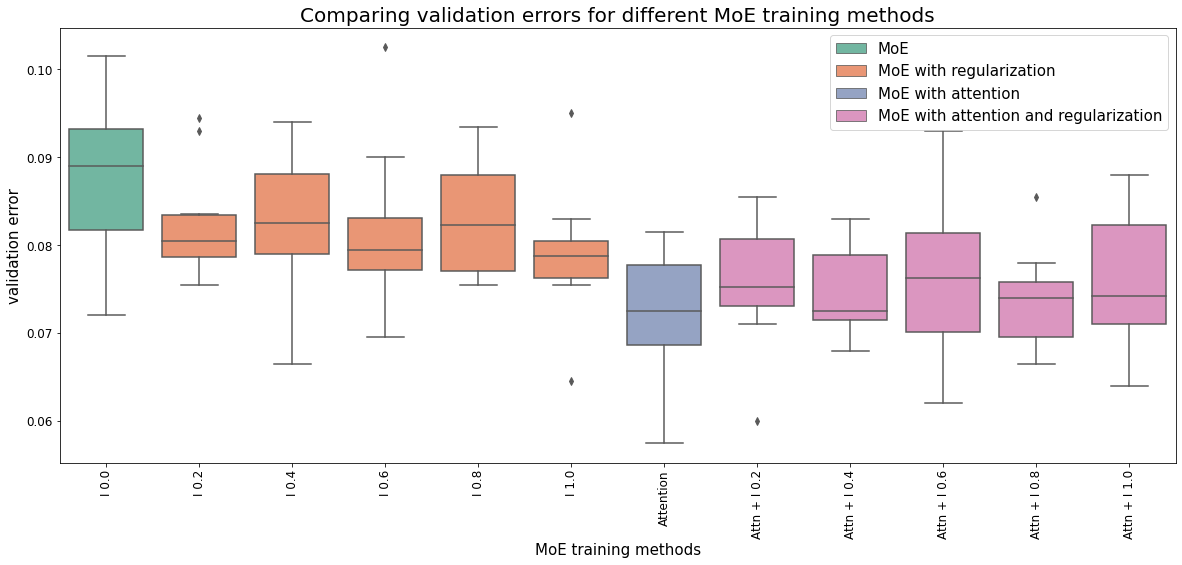

TypeError: unsupported operand type(s) for +=: 'NoneType' and 'str'

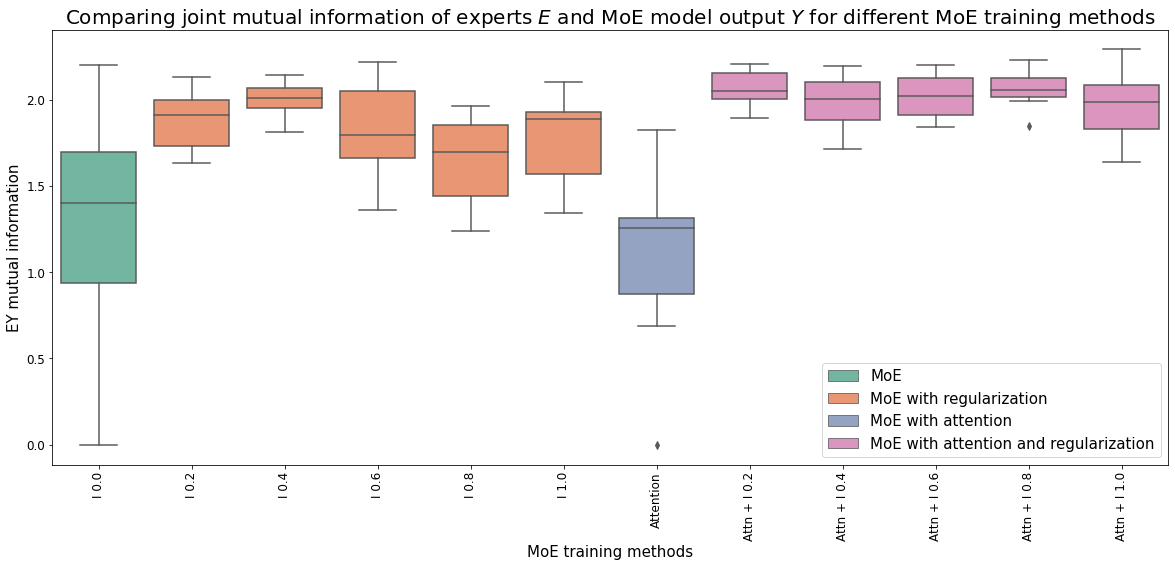

In [86]:
# model_single = 'mnist_single_model_hidden_32'
model_without_reg =  'mnist_without_reg_hidden_32'
model_with_reg = 'mnist_with_reg_hidden_32'
model_with_attention = 'mnist_with_attention_hidden_32'
model_with_attn_reg = 'mnist_with_attn_reg_hidden_32'

total_experts = 5
num_classes = 10
num_epochs = 20

temps = [[1.0]*num_epochs]
print(temps)
w_importance_range = [i * 0.2 for i in range(1, 6)]
print(w_importance_range)

boxplot(model_with_reg=model_with_reg, 
        model_without_reg=model_without_reg, 
        model_with_attention=model_with_attention, 
        model_with_attn_reg=model_with_attn_reg,
        temps=temps, w_importance_range=w_importance_range,
        total_experts=total_experts, num_classes=num_classes, classes=range(num_classes), testloader=testloader)


[1.1 1.2 1.3 1.4 1.5]
[0.2, 0.4, 0.6000000000000001, 0.8, 1.0]


<Figure size 432x288 with 0 Axes>

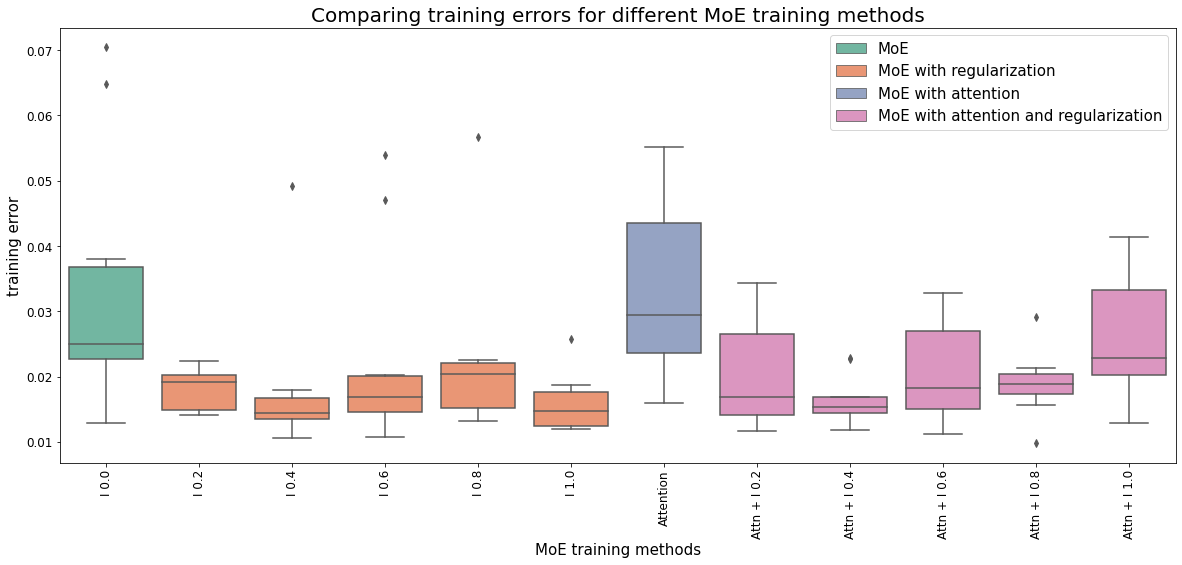

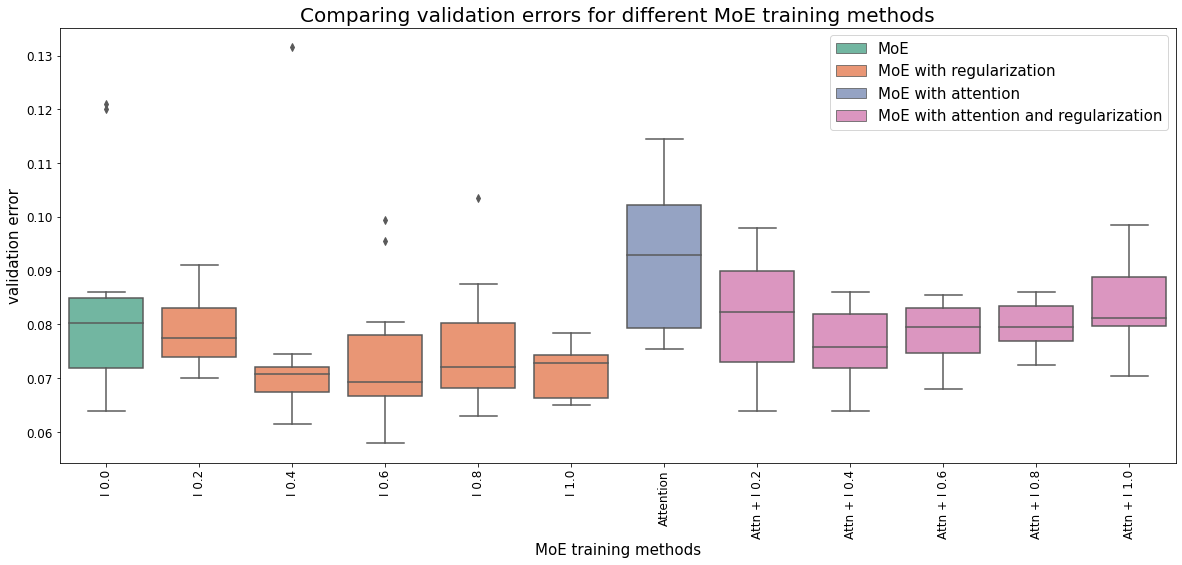

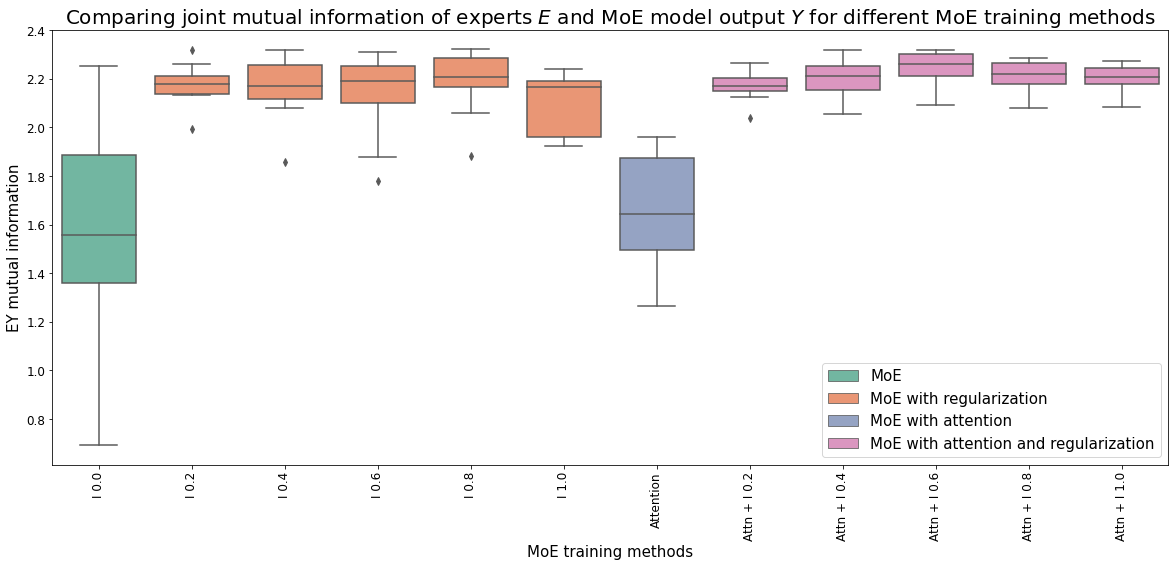

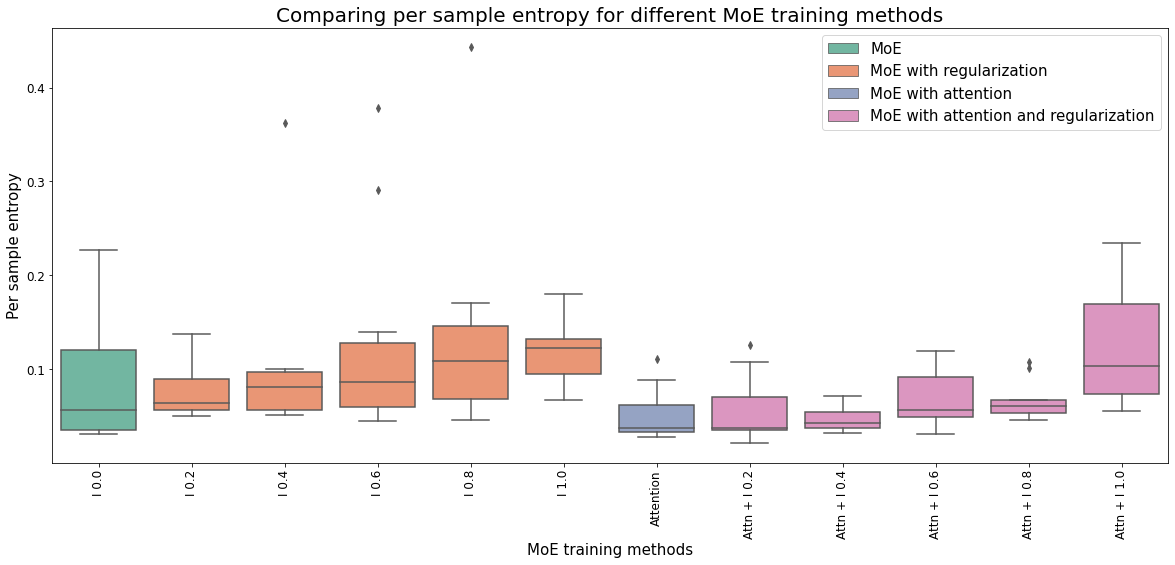

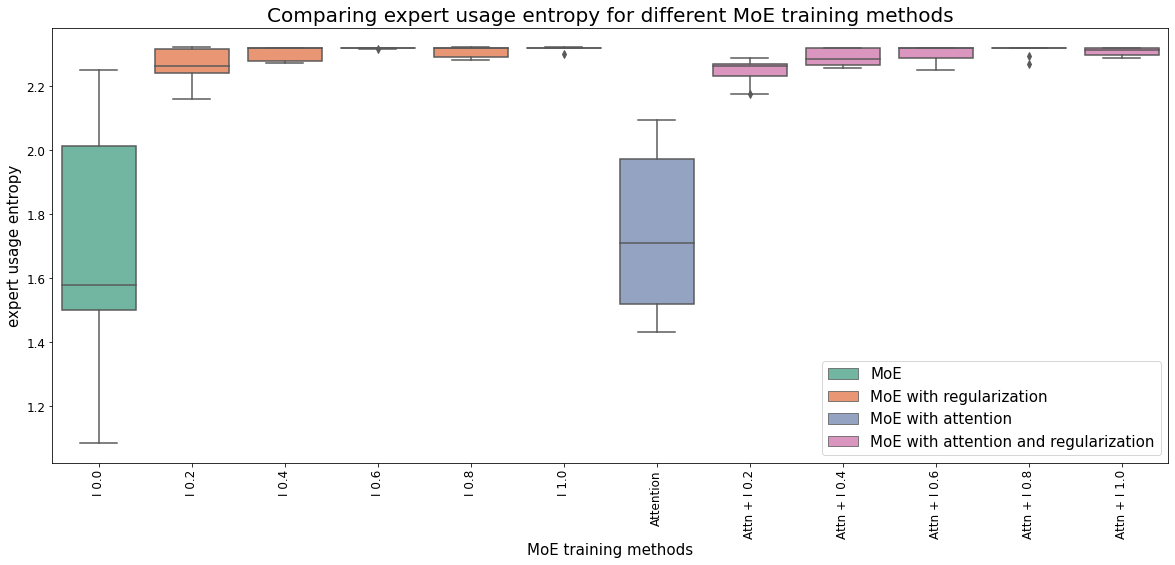

In [66]:
model_without_reg =  model_sample_sim_reg = 'mnist_transform_without_reg'
model_with_reg = 'mnist_transform_with_reg'
model_with_attention = 'mnist_with_attention'
model_with_attn_reg = 'mnist_with_attn_reg'
# model_dual_temp_with_attention = 'mnist_dual_temp_with_attention'
# model_with_temp = 'mnist_dual_temp'
# model_with_reg_temp = 'mnist_dual_temp_with_reg_test'
# mnist_attn_output_reg = 'mnist_attn_output_reg'

total_experts = 5
num_classes = 10

temps = [1.1,1.2]
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 21, 2), np.arange(25, 51, 5)))
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 7, 2)))
temps = np.arange(1.1,1.6,0.1)
print(temps)
w_importance_range = [i * 0.2 for i in range(1, 6)]
print(w_importance_range)

boxplot(
        model_with_reg=model_with_reg, model_without_reg=model_without_reg, 
        model_with_attention=model_with_attention,
        model_with_attn_reg=model_with_attn_reg, 
        temps=temps,w_importance_range=w_importance_range,
        total_experts=total_experts, num_classes=num_classes, classes=range(num_classes), 
        testloader=testloader, figname='mnist_attentive_gate')

In [ ]:
model_single = 'mnist_single_model'
model_with_attention =  'mnist_with_attention'
model_with_temp = 'mnist_dual_temp'
model_with_reg_temp = 'mnist_dual_temp_with_regularization'
model_with_temp_decay = 'mnist_dual_temp_on_schedule'
model_with_reg = 'mnist_with_regularization'
model_without_reg = 'mnist_without_regularization'

total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 6)))
temps = [1.2, 2.0]
w_importance_range = [i * 0.2 for i in range(1, 6)]

boxplot(model_single, model_with_attention, model_with_temp, model_with_temp_decay, model_with_reg, model_without_reg, model_with_reg_temp, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

In [ ]:
model_single = 'imbalanced_mnist_single_model'
model_with_temp = 'mnist_imbalanced_5_dual_temp'
model_with_temp_on_delay = 'mnist_imbalanced_5_dual_temp_on_schedule'
model_with_reg = 'mnist_imbalanced_5_with_regularization'
model_without_reg = 'mnist_imbalanced_5_without_regularization'
model_with_reg_temp = 'mnist_imbalanced_5_dual_temp_with_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(2, 6)))
temps = [1.2, 2.0]
w_importance_range = [i * 0.2 for i in range(1, 6)]

boxplot(model_single, model_with_temp, model_with_temp_on_delay, model_with_reg, model_without_reg, model_with_reg_temp, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

<Figure size 432x288 with 0 Axes>

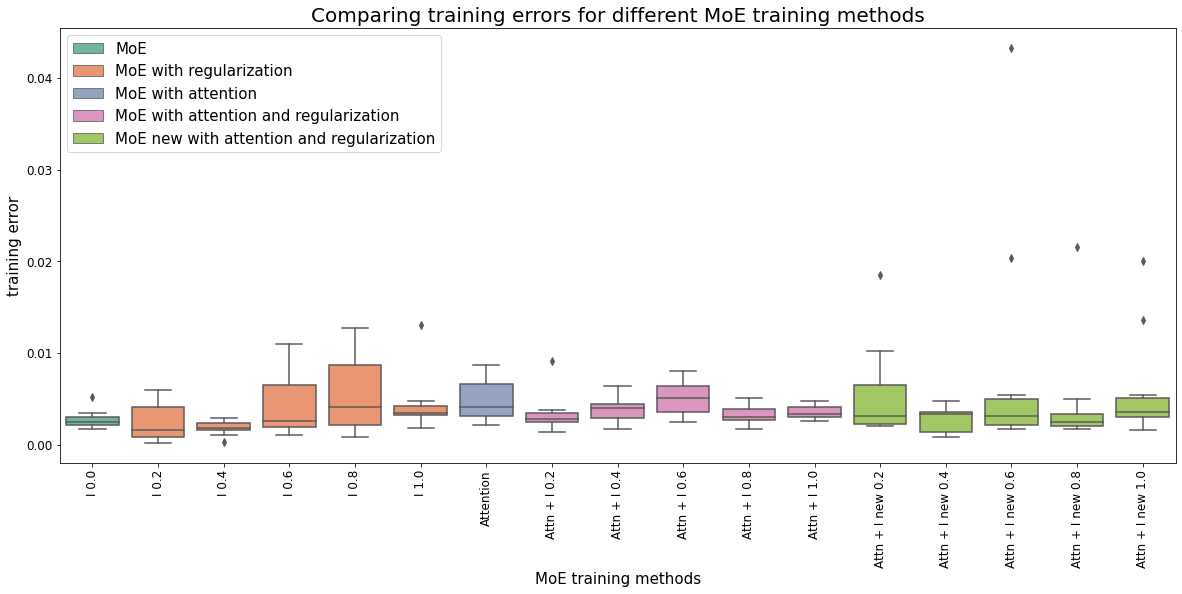

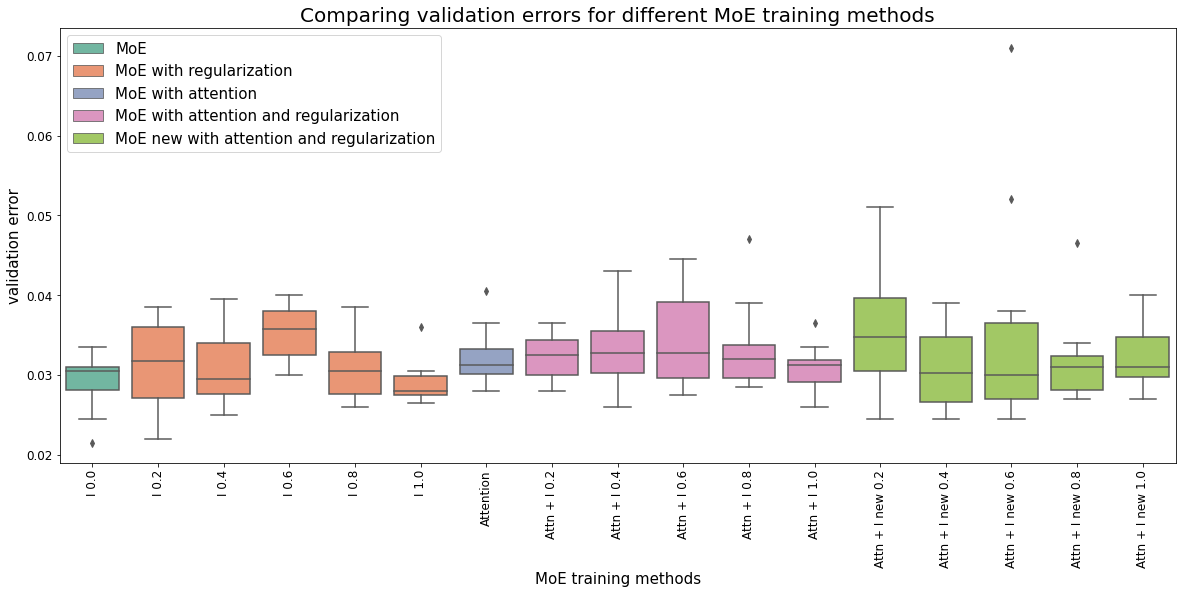

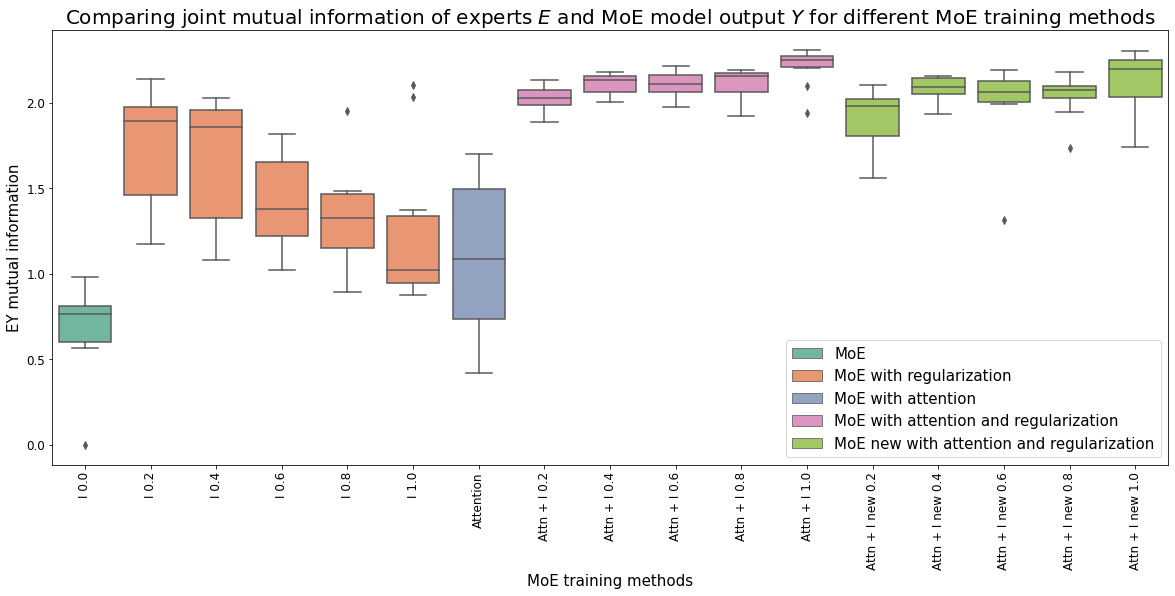

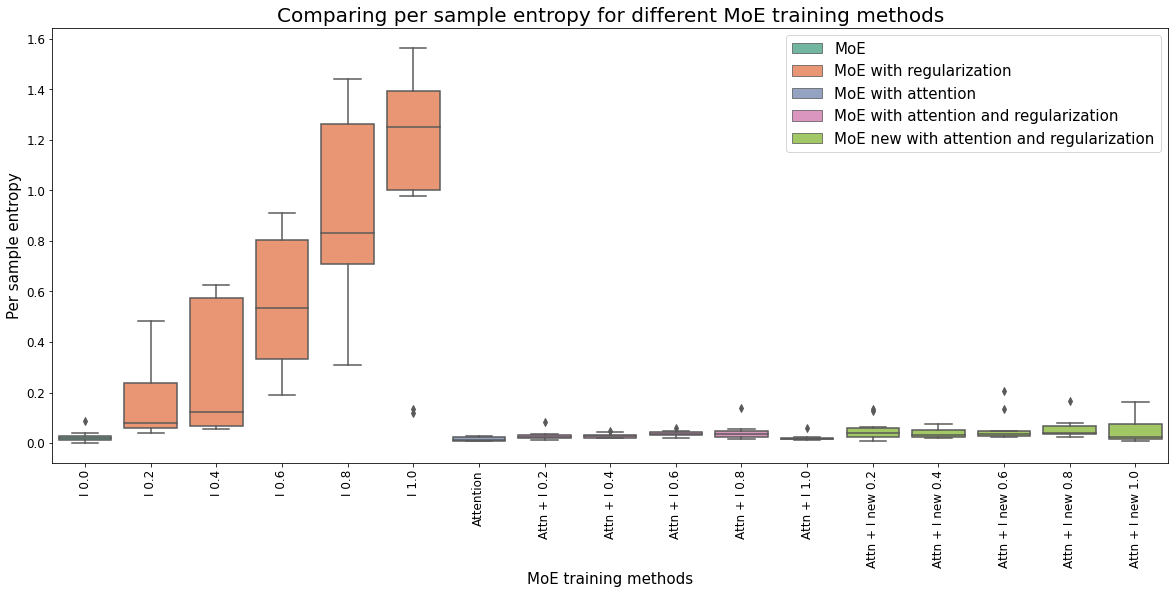

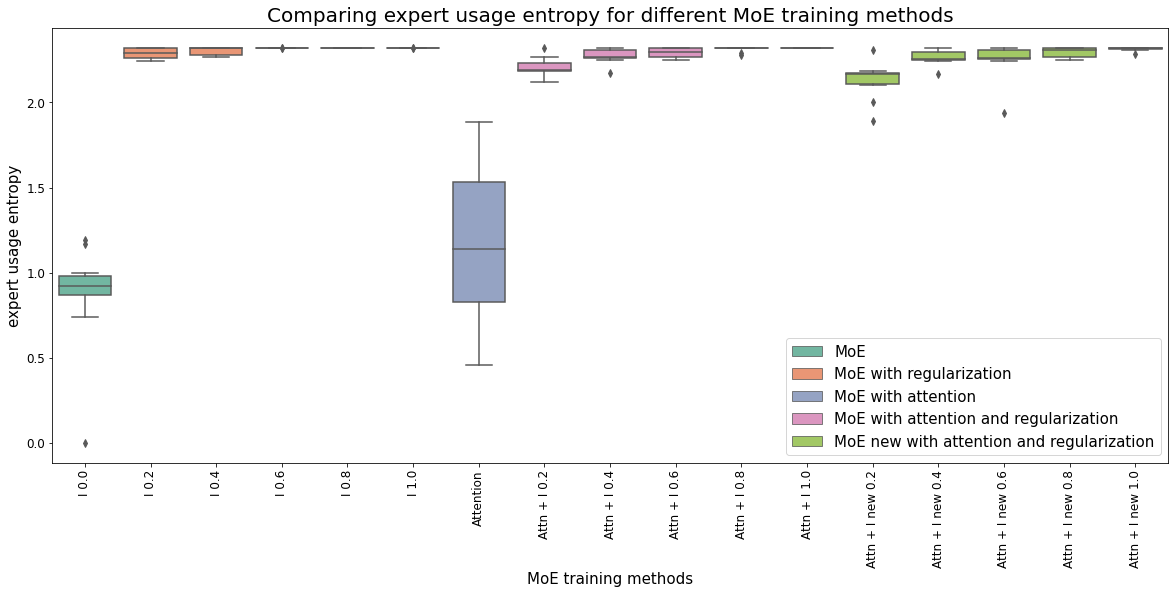

In [54]:
model_with_attention = {'ignore':'rot_mnist_with_attention_hidden_32'}
model_with_attn_reg = {'ignore':'rot_mnist_with_attn_reg_hidden_32', 'new':'new_rot_mnist_with_attn_reg_hidden_32'}
model_with_reg = {'ignore':'rot_mnist_with_reg_hidden_32'}
model_without_reg = {'ignore':'rot_mnist_without_reg_hidden_32'}

figname='rot_mnist_with_attention_hidden_32' 

total_experts = 5
num_classes = 10

w_importance_range = [i * 0.2 for i in range(1, 6)]

boxplot(model_with_reg=model_with_reg, model_without_reg=model_without_reg, model_with_attention=model_with_attention, model_with_attn_reg=model_with_attn_reg,
        w_importance_range=w_importance_range, total_experts=total_experts, num_classes=num_classes, classes=classes_rot_unrot_mnist, 
        testloader=rot_unrot_testloader, figname=figname , fig_path=fig_path, model_path=model_path)

<Figure size 432x288 with 0 Axes>

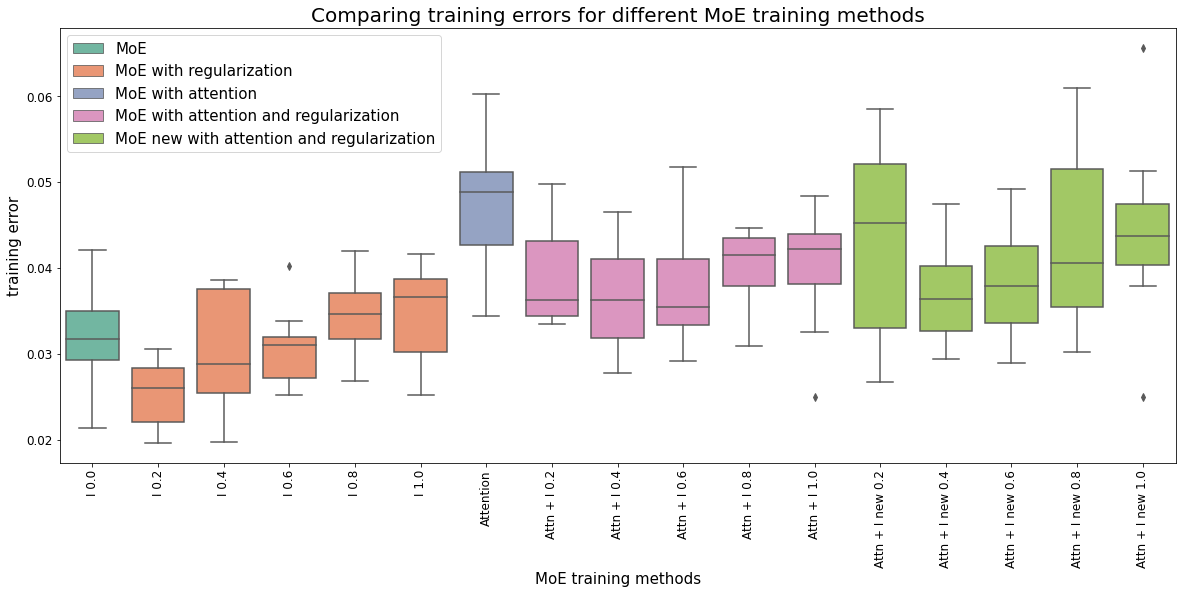

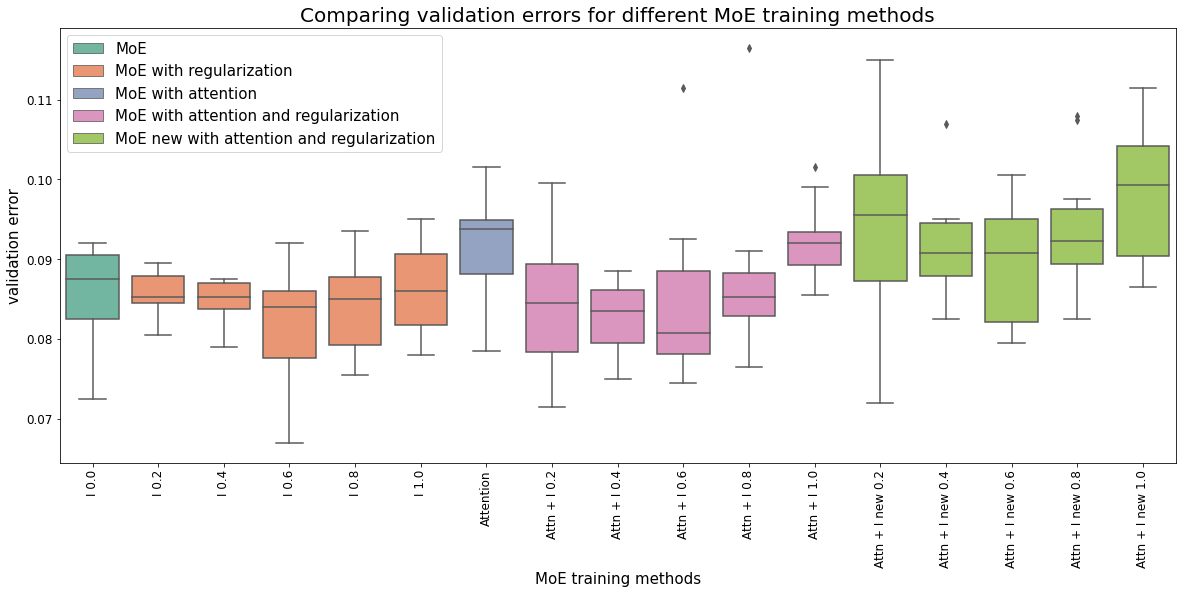

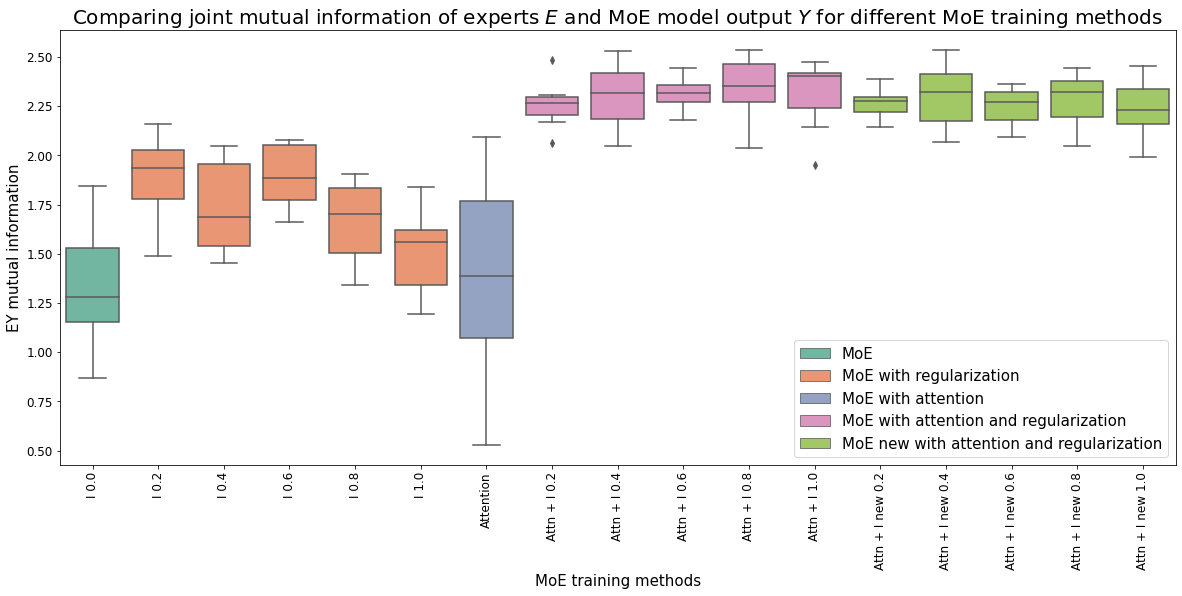

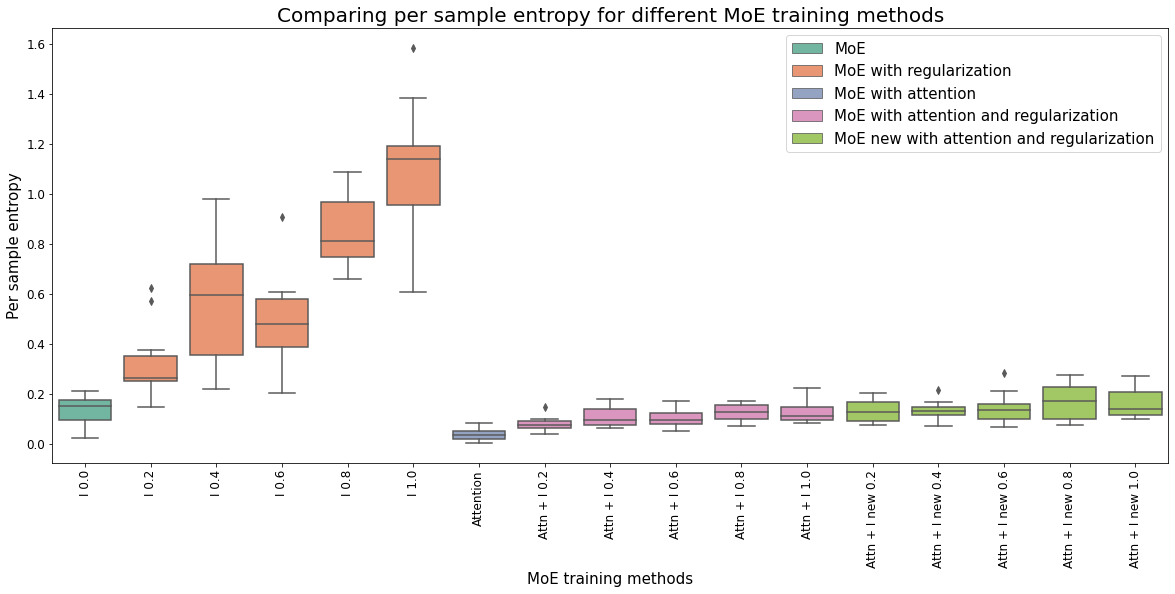

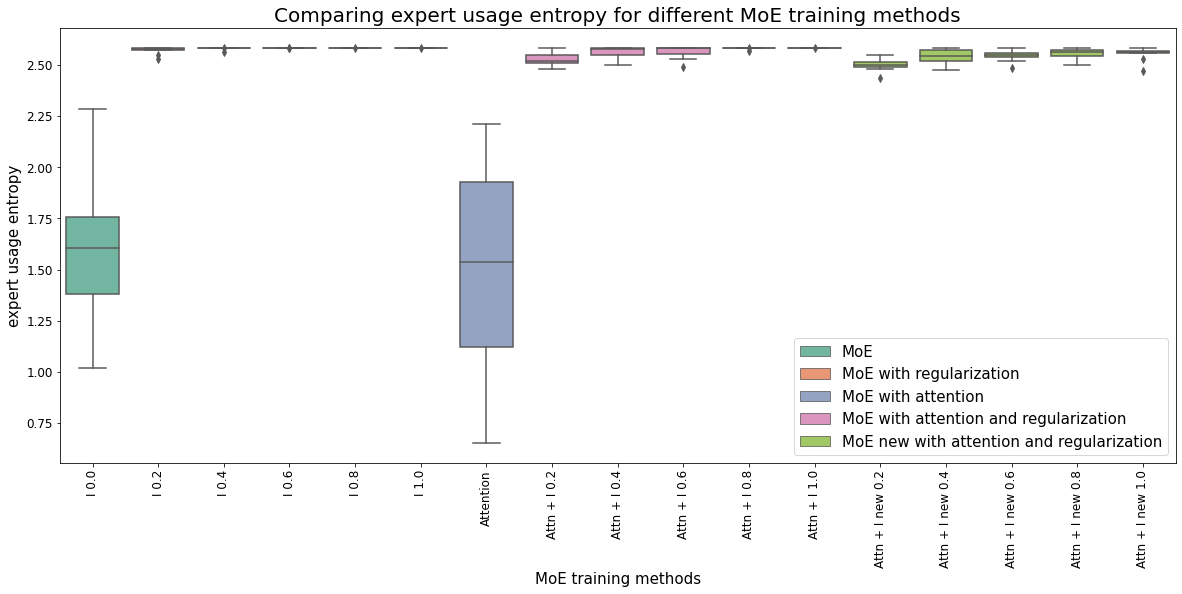

In [91]:
model_with_reg = {'ignore':'fmnist_mnist_with_reg_hidden_32'}
model_without_reg = {'ignore':'fmnist_mnist_without_reg_hidden_32'}
model_with_attention = {'ignore':'fmnist_mnist_with_attention_hidden_32'}
model_with_attn_reg = {'ignore':'fmnist_mnist_with_attn_reg_hidden_32','new':'new_fmnist_mnist_with_attn_reg_hidden_32'}

figname = 'fmnist_mnist_with_attention_hidden_32'
total_experts = 6

w_importance_range = [i * 0.2 for i in range(1, 6)]

boxplot(model_with_reg=model_with_reg, model_without_reg=model_without_reg, model_with_attention=model_with_attention, model_with_attn_reg=model_with_attn_reg,
        w_importance_range=w_importance_range, total_experts=total_experts, num_classes=num_classes_fmnist_mnist, classes=classes_fmnist_mnist, testloader=fmnist_mnist_testloader,
       figname=figname, fig_path=fig_path, model_path=model_path)

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_results(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
                 total_experts, num_classes, classes, testloader):
    
    num_epochs = 20

    min_values = []
    max_values = []
    mean_values = []
    std_values = []
    mutual_info = []
    models = []

    w_importance = 0.0

    for T in temps:    

        m = model_with_temp

        plot_file = generate_plot_file(m, w_importance,'temp_'+"{:.1f}".format(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')


        # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
        # model you build above
        model_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

        print('Model:', plot_file)

        error_values = []
        for model in model_1:
            for e_key, e_val in model.items():
                history = model[e_key]['experts'][total_experts]['history']
                error = 1-np.asarray(history['accuracy'])
                error_values.append(error[-1])

        models.append(model_1[np.argmin(error_values)])

        min_values.append("{:.3f}".format(min(error_values)))
        max_values.append("{:.3f}".format(max(error_values)))
        mean_values.append("{:.3f}".format(mean(error_values)))
        std_values.append("{:.3f}".format(np.std(error_values)))
        mutual_info.append("{:.3f}".format(history['mutual_EY'][-1]))

    T = [ 'T '+"{:.1f}".format(t) for t in temps]
    N_T = len(T)

    for w_importance in w_importance_range:

        m = model_with_reg

        plot_file = generate_plot_file(m, w_importance, str(num_classes)+'_'+str(total_experts)+'_models.pt')


        # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
        # model you build above
        model_2 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
        print('Model:', plot_file)

        error_values = []
        for model in model_2:
            for e_key, e_val in model.items():
                history = model[e_key]['experts'][total_experts]['history']
                error = 1-np.asarray(history['accuracy'])
                error_values.append(error[-1])

        models.append(model_2[np.argmin(error_values)])
#         models.append(model_2[-1])

        min_values.append("{:.3f}".format(min(error_values)))
        max_values.append("{:.3f}".format(max(error_values)))
        mean_values.append("{:.3f}".format(mean(error_values)))
        std_values.append("{:.3f}".format(np.std(error_values)))
        mutual_info.append("{:.3f}".format(history['mutual_EY'][-1]))

    N_I = len(w_importance_range)
    I = [ 'I '+"{:.1f}".format(i) for i in w_importance_range]

    m = model_without_reg

    plot_file = generate_plot_file(m, 0.0, str(num_classes)+'_'+str(total_experts)+'_models.pt')


    # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
    # model you build above
    model_3 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
    print('Model:', plot_file)

    error_values = []
    for model in model_3:
        history = model[e_key]['experts'][total_experts]['history']
        for e_key, e_val in model.items():
            error = 1-np.asarray(history['accuracy'])
            error_values.append(error[-1])

    models.append(model_3[np.argmin(error_values)])
#     models.append(model_3[-1])
    
    min_values.append("{:.3f}".format(min(error_values)))
    max_values.append("{:.3f}".format(max(error_values)))
    mean_values.append("{:.3f}".format(mean(error_values)))
    std_values.append("{:.3f}".format(np.std(error_values)))
    mutual_info.append("{:.3f}".format(history['mutual_EY'][-1]))

    method = T + I + ['I 0.0']
    N = N_T + N_I + 1

    print('N',N)
    data = np.hstack((np.asarray(method).reshape(N,1), np.asarray(min_values).reshape(N,1), np.asarray(max_values).reshape(N,1), 
                      np.asarray(mean_values).reshape(N,1), np.asarray(std_values).reshape(N,1), 
                      np.asarray(mutual_info).reshape(N,1)))

    print(data.shape)

    columns = ['Method', 'Min', 'Max', 'Mean', 'Std', 'Mutual Info']
    colors = np.array([['w']*len(columns)]*N)
    colors[np.argmin(data[:,1]), 1] = 'y'
    colors[np.argmax(data[:,2]), 2] = 'y'
    colors[np.argmin(data[:,3]), 3] = 'y'
    colors[np.argmin(data[:,4]), 4] = 'y'
    colors[np.argmax(data[:,5]), 5] = 'y'

    fig, ax = plt.subplots()
    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    ax.table(cellText=data, colLabels=columns, cellColours=colors, loc='center')

    fig.tight_layout()

    plt.show()


    model = models[np.argmin(data[0:N_T,1])]

    fig1,ax1 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 4))
    ax1.flatten()

    # Plotting for the model with reg
    for e_key, e_val in model.items():


        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                moe_model = e_val['experts'][total_experts]['model']

                # predict the classes for test data
                pred = moe_model(images)
                pred_labels = torch.argmax(pred, dim=1)

                expert_outputs = moe_model.expert_outputs
                gate_outputs = moe_model.gate_outputs

                # get the experts selected by the gate for each sample
                pred_gate_labels = torch.argmax(gate_outputs, dim=1)

                # plot the expert selection table
                print('\nExperts used by the gate for classification of each digit')
                class_expert_table = np.asarray([[0] * num_classes]*total_experts)
                for label, expert in zip(labels, pred_gate_labels):
                    class_expert_table[expert,label] += 1
                sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                            xticklabels=[classes[i] for i in range(0, num_classes)],
                            annot=True, cmap=cmap, fmt='d', ax=ax1[0])

                sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1[1], cmap=cmap, fmt='d')

                plt.show()


    model = models[N_T+np.argmin(data[N_T:N-1,1])]
    
    fig1,ax1 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 4))
    ax1.flatten()

    # Plotting for the model without reg
    for e_key, e_val in model.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                moe_model = e_val['experts'][total_experts]['model']

                # predict the classes for test data
                pred = moe_model(images)
                pred_labels = torch.argmax(pred, dim=1)

                expert_outputs = moe_model.expert_outputs
                gate_outputs = moe_model.gate_outputs

                # get the experts selected by the gate for each sample
                pred_gate_labels = torch.argmax(gate_outputs, dim=1)

                # plot the expert selection table
                print('\nExperts used by the gate for classification of each digit')
                class_expert_table = np.asarray([[0] * num_classes]*total_experts)
                for label, expert in zip(labels, pred_gate_labels):
                    class_expert_table[expert,label] += 1
                sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                            xticklabels=[classes[i] for i in range(0, num_classes)],
                            annot=True, cmap=cmap, fmt='d', ax=ax1[0])

                sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1[1], cmap=cmap, fmt='d')

                plt.show()

    model = models[-1]

    fig1,ax1 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 4))
    ax1.flatten()

    # Plotting for the model without reg
    for e_key, e_val in model.items():
        cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                moe_model = e_val['experts'][total_experts]['model']

                # predict the classes for test data
                pred = moe_model(images)
                pred_labels = torch.argmax(pred, dim=1)

                expert_outputs = moe_model.expert_outputs
                gate_outputs = moe_model.gate_outputs

                # get the experts selected by the gate for each sample
                pred_gate_labels = torch.argmax(gate_outputs, dim=1)

                # plot the expert selection table
                print('\nExperts used by the gate for classification of each digit')
                class_expert_table = np.asarray([[0] * num_classes]*total_experts)
                for label, expert in zip(labels, pred_gate_labels):
                    class_expert_table[expert,label] += 1
                sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                            xticklabels=[classes[i] for i in range(0, num_classes)],
                            annot=True, cmap=cmap, fmt='d', ax=ax1[0])

                sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1[1], cmap=cmap, fmt='d')

                plt.show()

    # plot error rates
    fig2,ax2 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(16,4))
    ax2 = ax2.flatten()

    fig3,ax3 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

    fig4,ax4 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))
    
    fig5,ax5 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(8,4))

    for i, model in enumerate(models):
        for e_key, e_val in model.items():

            # plot training and validation error rates
            sns.lineplot(x=range(num_epochs), y=1-np.asarray(model[e_key]['experts'][total_experts]['history']['accuracy']), ax=ax2[0])
            sns.lineplot(x=range(num_epochs), y=1-np.asarray(model[e_key]['experts'][total_experts]['history']['val_accuracy']), ax=ax2[1])

            # plot training loss
            sns.lineplot(x=range(num_epochs), y=np.asarray(model[e_key]['experts'][total_experts]['history']['loss']), ax=ax3)

            # plot mutual information
            sns.lineplot(x=range(num_epochs), y=np.asarray(model[e_key]['experts'][total_experts]['history']['mutual_EY']), ax=ax4)

            # plot mutual information
            sns.lineplot(x=range(num_epochs), y=np.asarray(model[e_key]['experts'][total_experts]['history']['H_EY']), ax=ax5)

    legend = data[:,0]

    ax2[0].legend(legend)

    ax2[0].set_xlabel('epochs')
    ax2[0].set_xticks(range(num_epochs+1))
    ax2[0].set_ylabel('train error rate')
    ax2[0].set_ylim(ymin=0)


    ax2[1].legend(legend)

    ax2[1].set_xlabel('epochs')
    ax2[1].set_xticks(range(num_epochs+1))
    ax2[1].set_ylabel('validation error rate')
    ax2[1].set_ylim(ymin=0)


    ax3.legend(legend)

    ax3.set_xlabel('epochs')
    ax3.set_xticks(range(num_epochs+1))
    ax3.set_ylabel('training loss')
    ax3.set_ylim(ymin=0)

    ax4.legend(legend)

    ax4.set_xlabel('epochs')
    ax4.set_xticks(range(num_epochs+1))
    ax4.set_ylabel('mutual information')
    ax4.set_ylim(ymin=0)
    
    ax5.legend(legend)

    ax5.set_xlabel('epochs')
    ax5.set_xticks(range(num_epochs+1))
    ax5.set_ylabel('Entropy EY')
    ax5.set_ylim(ymin=0)

    plt.show()


### Results for MNIST data

In [ ]:
model_with_temp = 'mnist_dual_temp'
model_with_reg = 'mnist_with_regularization'
model_without_reg = 'mnist_without_regularization'
total_experts = 5
num_classes = 10
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

In [ ]:
model_with_temp = 'mnist_imbalanced_5_dual_temp'
model_with_reg = 'mnist_imbalanced_5_with_regularization'
model_without_reg = 'mnist_imbalanced_5_without_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes, range(num_classes), testloader)

In [ ]:
model_with_temp = 'rot_mnist_dual_temp'
model_with_reg = 'rot_mnist_with_regularization'
model_without_reg = 'rot_mnist_without_regularization'
total_experts = 5
num_classes = 10

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

rot_unrot_mnist_classes = ['0','1','2','3','4','rotated 0', 'rotated 1', 'rotated 2', 'rotated 3', 'rotated 4']
plot_results(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
             total_experts, num_classes,rot_unrot_mnist_classes , rot_unrot_testloader)

### Results for combined FMNIST and MNIST data

In [ ]:
model_with_temp = 'fmnist_mnist_dual_temp'
model_with_reg = 'fmnist_mnist_with_regularization'
model_without_reg = 'fmnist_mnist_without_regularization'
total_experts = 6

temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]

plot_results(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
             total_experts, num_classes_fmnist_mnist, classes_fmnist_mnist, fmnist_mnist_testloader)

In [ ]:
def plot_gate_prob(model_with_temp, model_with_reg, model_without_reg, temps, w_importance_range,
                 total_experts, num_classes, classes, testloader):
    
    w_importance = 0.0
    
    for T in temps:    

        m = model_with_temp

        plot_file = generate_plot_file(m, w_importance,'temp_'+"{:.1f}".format(T)+'_'+str(num_classes)+'_'+str(total_experts)+'_models.pt')


        # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
        # model you build above
        model = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)[5]
        
        for e_key, e_val in model.items():
            history = model[e_key]['experts'][total_experts]['history']
            mean_gate_probability = np.asarray(history['mean_gate_probability'])
            var_gate_probability = np.asarray(history['var_gate_probability'])
            print('Temperature ', "{:.1f}".format(T))
            print(mean_gate_probability.shape)
            plt.imshow(np.transpose(mean_gate_probability))
            plt.show()
            plt.imshow(np.transpose(var_gate_probability))
            plt.show()
        
    

#     for w_importance in w_importance_range:

#         m = model_with_reg

#         plot_file = generate_plot_file(m, w_importance, str(num_classes)+'_'+str(total_experts)+'_models.pt')


#         # Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
#         # model you build above
#         model_2 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
# #         print('Model:', plot_file)

#         error_values = []
#         for model in model_2:
#             for e_key, e_val in model.items():
#                 history = model[e_key]['experts'][total_experts]['history']
#                 error = 1-np.asarray(history['accuracy'])
#                 val_error = 1-np.asarray(history['val_accuracy'])
#                 y_error.append(error[-1])
#                 y_val_error.append(val_error[-1])
#                 y_mi.append(history['mutual_EY'][-1])
#                 y_H_EY.append(history['H_EY'][-1])
#                 y_sample_H.append(history['sample_entropy'][-1])
#                 x.append('I '+"{:.1f}".format(w_importance))


In [ ]:
model_with_temp = 'fmnist_mnist_dual_temp'
model_with_reg = 'fmnist_mnist_with_regularization'
model_without_reg = 'fmnist_mnist_without_regularization'
total_experts = 6
temps = np.concatenate((np.arange(1.1,1.6,0.1), np.arange(0.9,0.4,-0.1)))
w_importance_range = [i * 0.2 for i in range(1, 6)]
plot_gate_prob(model_with_temp, model_with_reg, model_without_reg, temps,w_importance_range,
             total_experts, num_classes_fmnist_mnist, classes_fmnist_mnist, fmnist_mnist_testloader)